<a href="https://colab.research.google.com/github/oskarnurm/AutoPricer/blob/main/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Predicting car price

## Authors: Ludwig Estling, Elias Hedlin, Oskar Nurm, Leo Lundberg

---

### Background and motivation

When buying a car it can be difficult to assess whether the price is too high, or if you are selling your car for a price too low.

We wanted to create a model that could as accurately as possible predict the price of an arbitrary car with a model year no older than ~1990. We went about achieving this with the dataset (Car Features and MSRP | Kaggle). The idea was to train a model on a car's more “basal” features like cylinder amount, car brand, driven wheels etc. We hoped to see what underlying features that would or would not have a great influence on a car’s price and to have some kind of more “objective” measurement of a car's value.
The results of this project could be used by car retailers to set the price of their cars more effectively as well as consumers to determine whether the price of a car is fair.


### Dataset

The [dataset](https://www.kaggle.com/datasets/CooperUnion/cardataset) we used consists of 11684 rows, each row representing a unique car. Each row has 16 columns.

The dataset was put together by the user Cooperunion on Kaggle in 2017. Thus the dataset contains cars up to 2017 and the price is also represented by 2017 prices. Also noteworthy is that Edmunds is an american company, thus the price is denoted in USD.

The data was mostly scraped from the car retailer Edmunds. On their website they have an application that lets users appraise their cars based on different parameters. These parameters are some of the features found in our dataset.

The feature “Popularity” was scraped from twitter, representing how much a specific car is talked about.



### Methodology


The main goal with this project was to predict the price of cars by using the aforementioned dataset, using different methods for Unsupervised- & Supervised learning, dimensionality reduction/feature selection. Before starting with any kind of machine learning we explored our dataset, ultimately cleaning it as you will see further down in the code section of the report. The Unsupervised methods we used were clustering, in particular we tried KModes & KPrototypes.  KPrototypes being a combination between KModes and KMeans clustering. This was chosen because it can be used on datasets with mixed data types, to see if we could see any similarities between our data points. For our numerical features we used principal component analysis (PCA) to visualise and also to reduce dimensions.


To actually predict the price we used different regression algorithms, specifically “least absolute shrinkage and selection operator” (LASSO),  Linear Regression & Random Forest Regression. Lasso being a modified Linear Regression, that tries to use as few parameters as possible to fit a line. The Random Forest is a lot of decision trees that predict the price and then returns the average of the predictions.


Before actually applying the different algorithms we split the dataset into a training set, an evaluation set and a test set. The evaluation set was used to fine-tune the parameters before testing it on the test set. This in order to get a better estimate of how well our model would generalize to new, unseen data if ever to be deployed into the real world.
Before actually training our model we also One Hot Encoded (OHE) our categorical features, meaning that every categorical value becomes a feature of a data point with the value 0 or 1. E.G if a datapoint has the make-value “Volvo” it instead gets a feature called “Is Volvo” with the value 1 (it also gets for example a feature called “Is Ford” with the value 0).


To evaluate the project we mainly looked at the resulting RMSE (Root of the mean of the square error) of the predictions and also the R^2 score, which describes the amount of variance that can be described by the regression model. To evaluate we looked at the prediction of the actual price and the logarithmic price.


---

In [ ]:
import os
import math
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Import the data

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Set up Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'floydthebarber'
os.environ['KAGGLE_KEY'] = 'a502a7c466b41fb511359969df06a8d6'

# Download the dataset
!kaggle datasets download -d CooperUnion/cardataset

# Extract the CSV file from the ZIP archive
with zipfile.ZipFile('cardataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the dataset into a pandas DataFrame
df = pd.read_csv('data.csv')

# Set column names
column_names = ['make', 'model', 'year', 'engine_fuel_type', 'engine_hp', 'engine_cylinders',
                'transmission_type', 'driven_wheels', 'number_of_doors', 'market_category',
                'vehicle_size', 'vehicle_style', 'highway_mpg', 'city_mpg', 'popularity', 'MSRP']
df.columns = column_names

cardataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# EDA

In [ ]:
# Calculate the number of missing values per column
missing_values = df.isnull().sum()

# Print the number of missing values per column
print(missing_values)

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
MSRP                    0
dtype: int64


In [ ]:
# Calculate the number of rows with missing data
rows_with_missing_data = df.isnull().any(axis=1).sum()

# Calculate the percentage of rows with missing data
percentage_missing_data = (rows_with_missing_data / len(df)) * 100

# Print the results
print(f"Number of rows with missing data: {rows_with_missing_data}")
print(f"Percentage of rows with missing data: {percentage_missing_data:.2f}%")

Number of rows with missing data: 3830
Percentage of rows with missing data: 32.15%


From rudimentary initial data visualisation we immediately discarded the feature "market category". The feature has a lot of NaN values or several values for one row (car), making it a problematic feature to include.

In [ ]:
# Drop Market-category
df.drop(columns=['market_category'], inplace=True)

In [ ]:
# Calculate the number of rows with missing data
rows_with_missing_data = df.isnull().any(axis=1).sum()

# Calculate the percentage of rows with missing data
percentage_missing_data = (rows_with_missing_data / len(df)) * 100

# Print the results
print(f"Number of rows with missing data: {rows_with_missing_data}")
print(f"Percentage of rows with missing data: {percentage_missing_data:.2f}%")

Number of rows with missing data: 102
Percentage of rows with missing data: 0.86%


We drop the rest of rows that have any NaN values since we only lose a very small amount of data.

In [ ]:
# Drop rows with missing values in the original DataFrame
df.dropna(inplace=True)

Here we plot our numeric features in histograms, as well as boxplots. The circles in the boxplots represent outliers. The outliers are classified with the IQR, Interquartile range rule. The IQR and the lower and upper limits are calculated as following:

Q1 is the first quartile, Q3 is the third quartile.

```
IQR = Q3 - Q1
lower_limit = IQR - 1.5*Q1
upper_limit = IQR + 1.5*Q3
```

Everything below the lower limit and above the upper limit is defined as an outlier.
As we can see in the plot, there are alot of outliers.


In [ ]:
# Seperate the numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

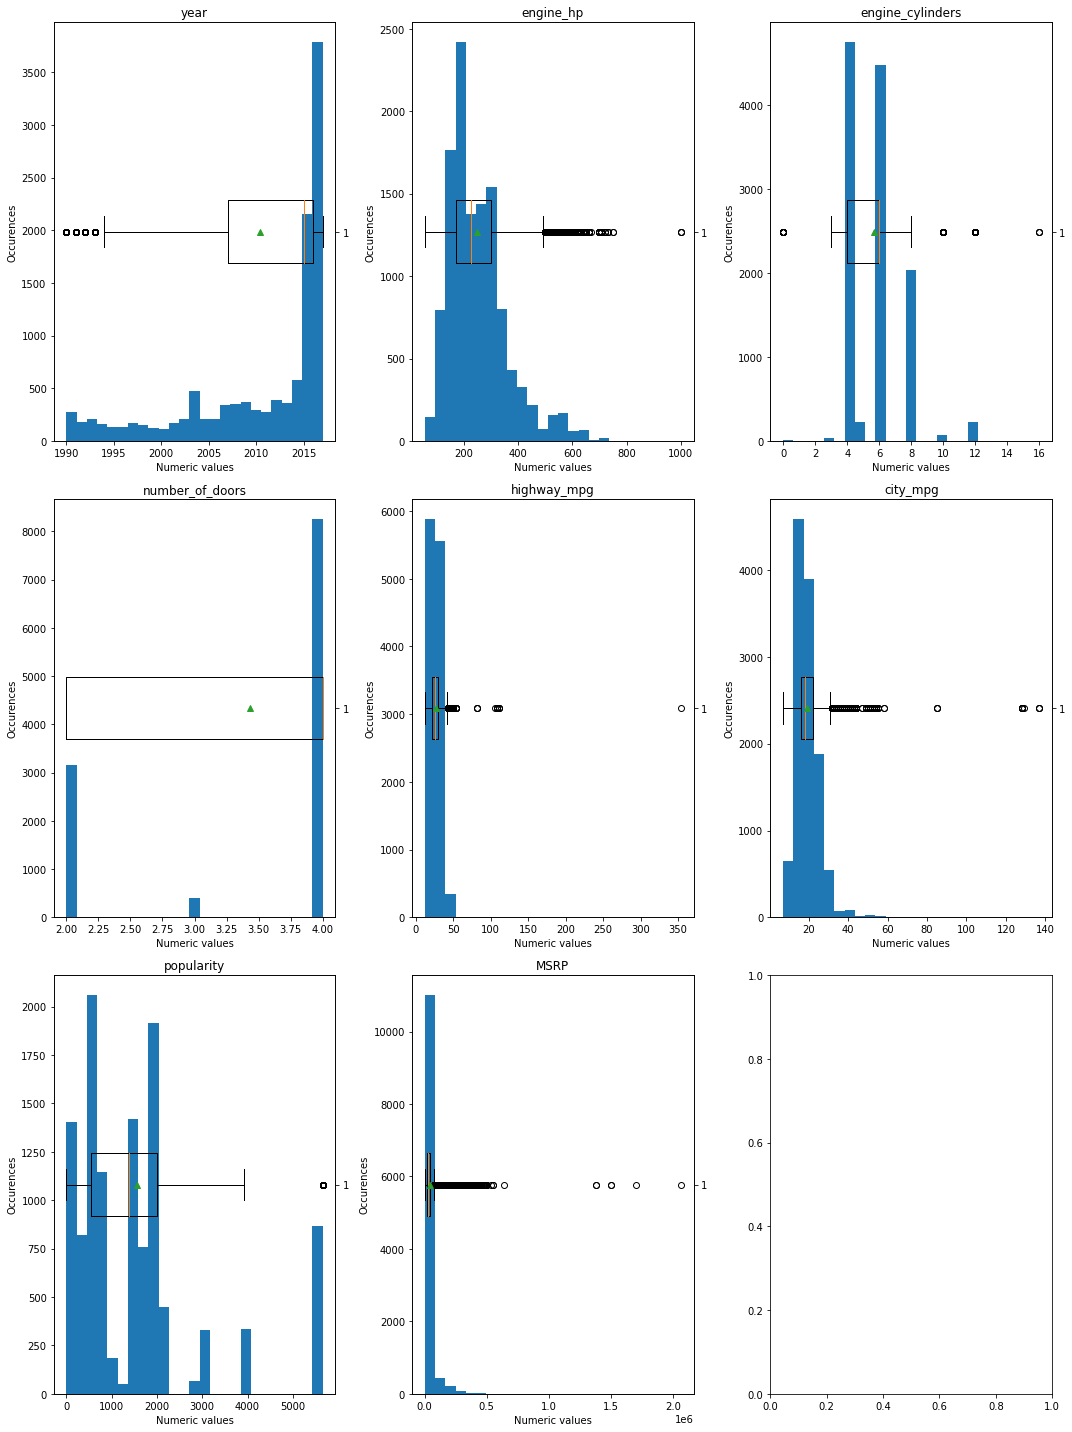

In [ ]:
df_numeric = df._get_numeric_data()
numeric_cols = df_numeric.columns
fig, axs = plt.subplots(ncols = 3,
                        nrows=int(np.ceil(len(numeric_cols)/3)),
                        figsize = (15, 20))

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0.2),  # blue  with alpha = 20%
})


i = 0
for ax in axs.flatten():
  ax2 = ax.twinx()
  col = numeric_cols[i]
  data = df_numeric.__getattr__(col)
  n, bins, _ = ax.hist(data, bins=25)
  ax.set_ylabel('Occurences')
  ax.set_xlabel('Numeric values')
  ax.set_title(col)
  ax.tick_params(axis='y', labelsize=10)
  bp = ax2.boxplot(data, vert=False, showmeans=True)
  i += 1
  if i > (len(numeric_cols)-1):
    break

fig.tight_layout()

Here we plot our categorical features in barcharts.

The bars are accompanied by the percentage of cars with that value as well as the amount.
Here we can see that there are alot of values in the different categories that make up a very small percentage of the dataset. These might also be considered outliers.

Also note that all of these categories can be considered nominal.


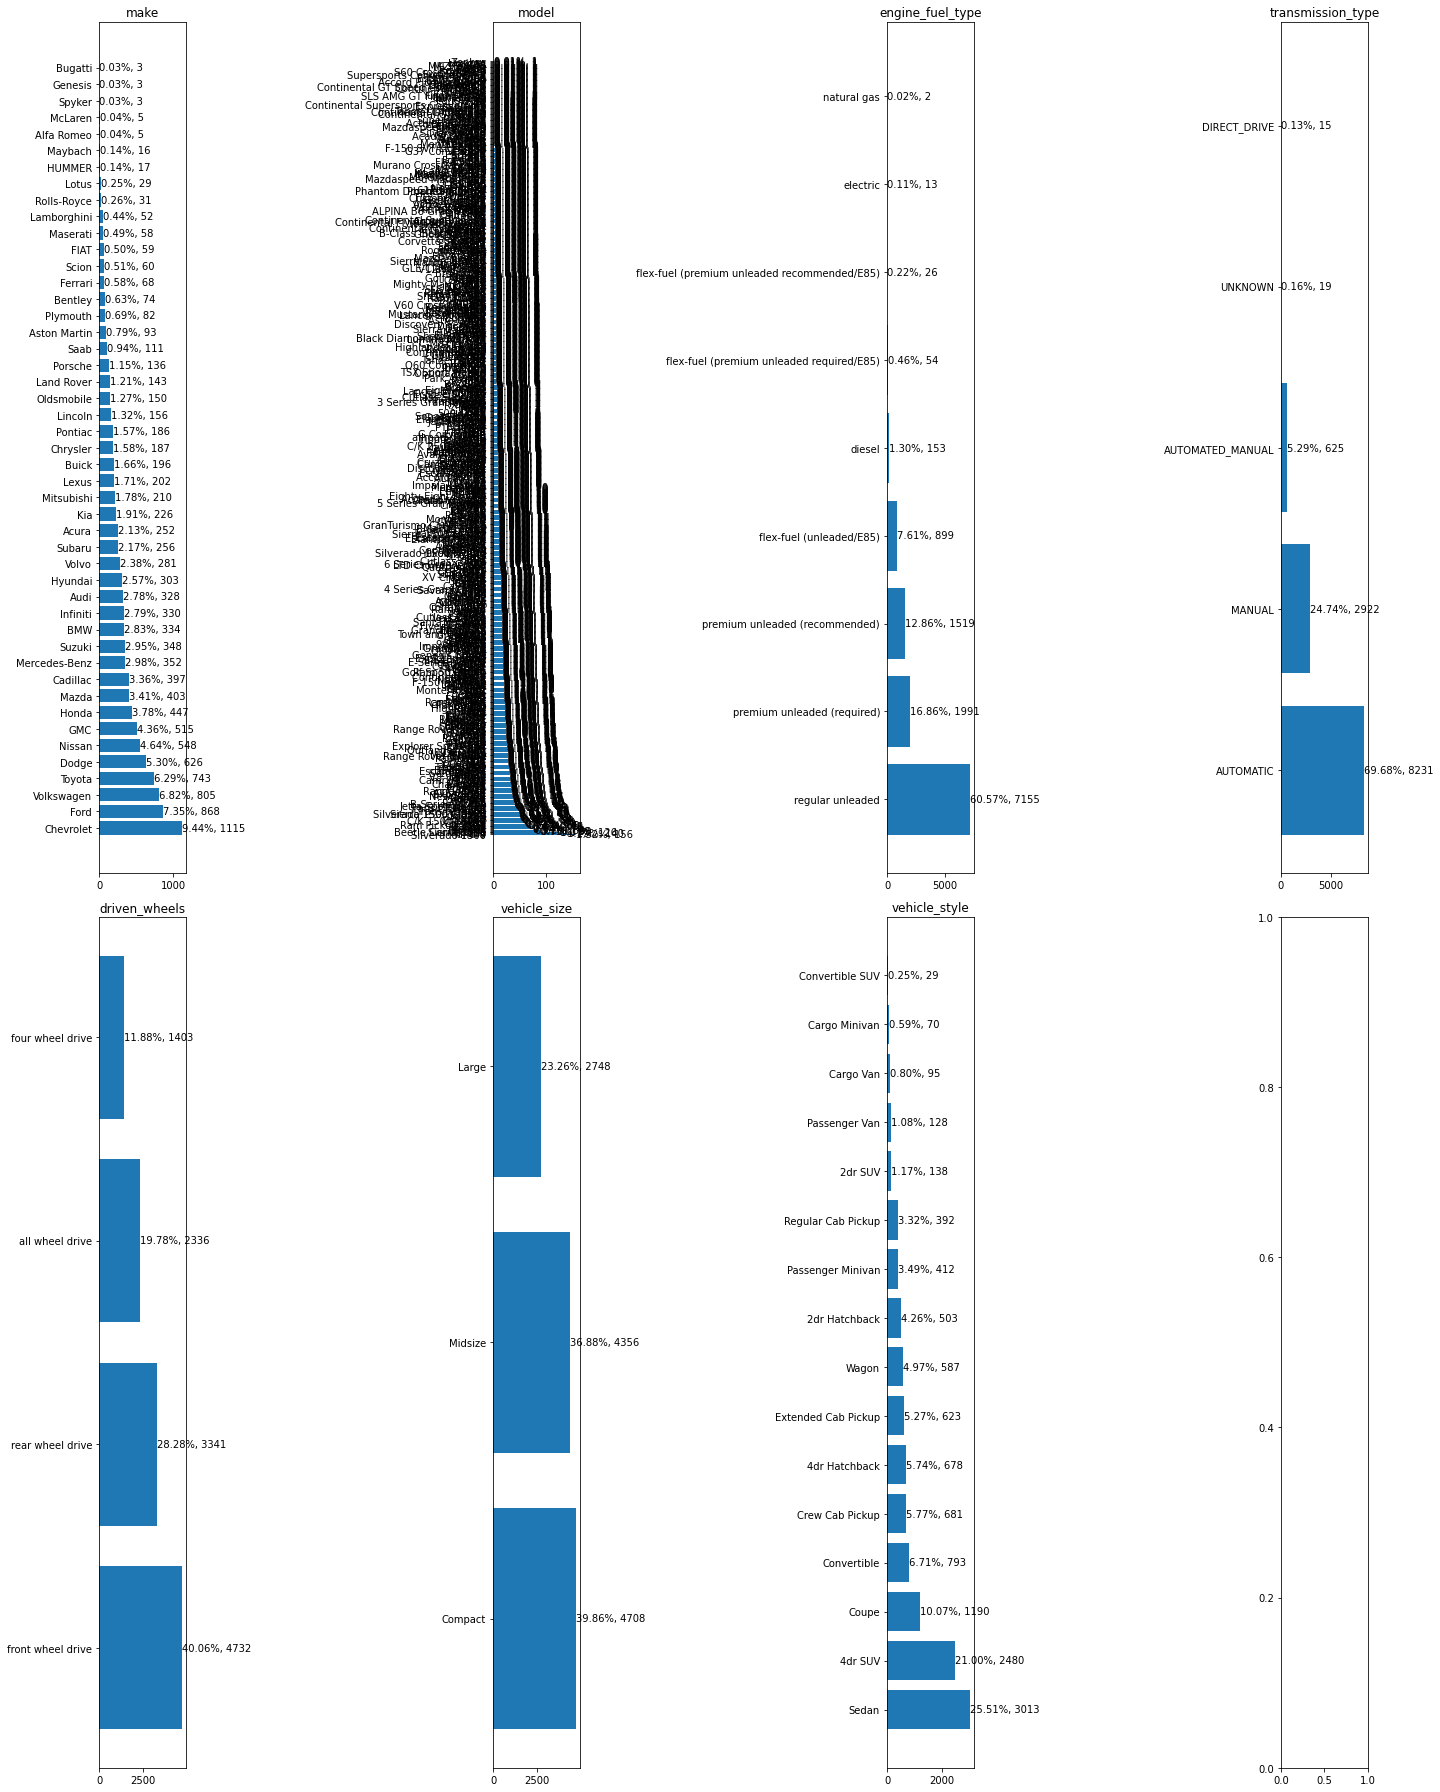

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=int(np.ceil(len(categorical_cols) / 4)), figsize=(20, 25))

for i, (ax, col) in enumerate(zip(axs.flatten(), categorical_cols)):
    count_per_val = df[col].value_counts(ascending=False)
    total_count = count_per_val.sum()
    ax.barh(count_per_val.index, width=count_per_val.values)
    for container in ax.containers:
        for bar in container:
            proportion = bar.get_width() / total_count
            ax.text(bar.get_x() + bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2, f"{proportion:.2%}, {bar.get_width()}",
                    ha='left', va='center')
    ax.set_title(col)

fig.tight_layout()

The transmission feature has a value 'UNKNOWN' which is clearly an anomoly. So we drop all of those cars who's transmission is UNKNOWN.

We also drop the entire column model because the data therein is too sparse.

In [ ]:
df.drop(df[df['transmission_type']=='UNKNOWN'].index, axis='index', inplace = True)
df.drop('model',axis=1, inplace=True)

# Unsupervised


## Clustering

In this step we try to find a good amount k of clusters to use by using the elbow method where the goal is to minimise the cost with as few clusters as possible. As we see in the plot below there is no clear outcome. When doing the same thing with only the categorical features we could see a clear elbow at k = 5, so we move forward using this value.

In [ ]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from kmodes.kmodes import KModes
from plotnine import *
import plotnine

In [ ]:
df_no_MSRP = df.drop('MSRP', axis=1, inplace=False)

# Source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7

# Extract the numeric columns
numeric_cols = df_no_MSRP.select_dtypes(include='number').columns

# Create a StandardScaler object and fit_transform the numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

# Replace the original numeric columns with the scaled data
df_no_MSRP[numeric_cols] = scaled_data

catColumnsPos = [df_no_MSRP.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
dfMatrix = df_no_MSRP.loc[:,:].to_numpy() # convert catagorical to matrix


cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0, verbose=1, max_iter=10)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except Exception as err:
        print(err)
        break




In [ ]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost': cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

The loop in the code takes 1 hour or more to execute. So below we atteched the resulting plot of the code above.

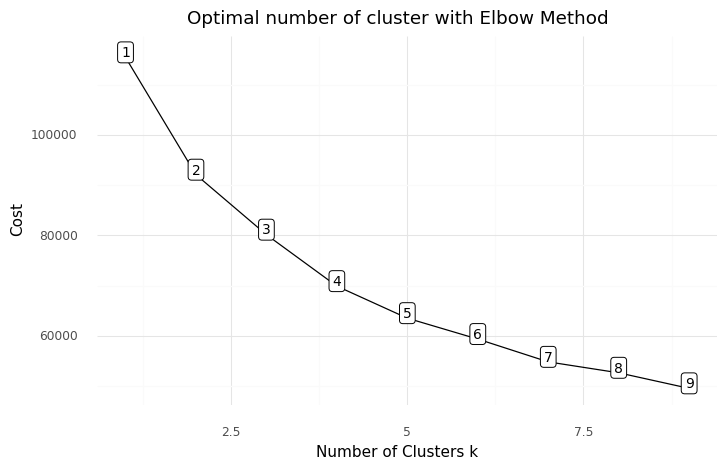

In [ ]:
# Dropping the target variable because the clusting is supposed to be unsupervised
df_no_MSRP = df.drop(['MSRP'], axis=1, inplace=False)

# Extract the numeric columns
numeric_cols = df_no_MSRP.select_dtypes(include='number').columns

# Create a StandardScaler object and fit_transform the numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_MSRP[numeric_cols])

# Replace the original numeric columns with the scaled data
df_no_MSRP[numeric_cols] = scaled_data

catColumnsPos = [df_no_MSRP.columns.get_loc(col) for col in list(df_no_MSRP.select_dtypes('object').columns)]

# Source for alot of the code in this section
# https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
dfMatrix = df_no_MSRP.loc[:,:].to_numpy() # convert catagorical to matrix

kprototype = KPrototypes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0, verbose=1, max_iter=10)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)



Best run was number 8


array([1, 1, 1, ..., 3, 3, 3], dtype=uint16)

In [ ]:
# Cluster centorid
print(kprototype.cluster_centroids_)
# Check the iteration of the clusters created
print(kprototype.n_iter_)
# Check the cost of the clusters created
print(kprototype.cost_)

[['-1.6686319206854616' '-0.7488717013959033' '-0.2151269272445044'
  '-0.7547154189653478' '-0.3092837567308162' '-0.2513468437255779'
  '-0.3487372040673324' 'Chevrolet' 'regular unleaded' 'MANUAL'
  'front wheel drive' 'Compact' 'Sedan']
 ['0.02981840517837451' '0.039743819033410906' '0.1758197900300412'
  '-0.1226512164891914' '-0.2756147457294352' '-0.2791176071879408'
  '2.6167714455301945' 'Ford' 'regular unleaded' 'AUTOMATIC'
  'rear wheel drive' 'Large' 'Sedan']
 ['0.37156837606708115' '1.790850044880388' '1.4319923147243425'
  '-1.2159649872290659' '-0.6139375431363103' '-0.7155565447302267'
  '-0.15431971261856686' 'Chevrolet' 'premium unleaded (required)'
  'AUTOMATIC' 'rear wheel drive' 'Compact' 'Coupe']
 ['0.27574820550805873' '0.3854438481723031' '0.45156042826905524'
  '0.6334894239424284' '-0.4357322161282059' '-0.42217995859207813'
  '-0.2788975296104683' 'Chevrolet' 'regular unleaded' 'AUTOMATIC'
  'all wheel drive' 'Midsize' '4dr SUV']
 ['0.5178908017107865' '-0.64

In [ ]:
df_clustering = df.drop('MSRP', axis =1, inplace=False)
numeric_cols = df_clustering.select_dtypes(include='number').columns
scaled_back_data = scaler.inverse_transform(scaled_data, copy=False)

df_clustering[numeric_cols] = scaled_back_data

df_clustering['Cluster Labels'] = kprototype.labels_
df_clustering['Segment'] = df_clustering['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'})
# Order the cluster
df_clustering['Segment'] = df_clustering['Segment'].astype('category')
df_clustering['Segment'] = df_clustering['Segment'].cat.reorder_categories(['First', 'Second', 'Third','Fourth','Fifth'])

In [ ]:
display(df_clustering)
display(df_clustering['Segment'].value_counts())

,make,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,Cluster Labels,Segment
0,BMW,2011.0,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,26.0,19.0,3916.0,1,Second
1,BMW,2011.0,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28.0,19.0,3916.0,1,Second
2,BMW,2011.0,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28.0,20.0,3916.0,1,Second
3,BMW,2011.0,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Coupe,28.0,18.0,3916.0,1,Second
4,BMW,2011.0,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,28.0,18.0,3916.0,1,Second
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,2012.0,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23.0,16.0,204.0,3,Fourth
11910,Acura,2012.0,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23.0,16.0,204.0,3,Fourth
11911,Acura,2012.0,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23.0,16.0,204.0,3,Fourth
11912,Acura,2013.0,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23.0,16.0,204.0,3,Fourth


Fourth    3719
Fifth     3634
First     2062
Third     1352
Second    1026
Name: Segment, dtype: int64

In [ ]:
# Columns for centroids
list_col = ['Cluster Labels', 'Segment']
cat_cols = [col for col in df_clustering.select_dtypes('object') if col not in list_col]
numeric_cols = [col for col in df_clustering.select_dtypes('number') if col not in list_col]
cols= numeric_cols + cat_cols
# Create an index for cluster interpretation
index = ['First Cluster', 'Second Cluster', 'Third Cluster', 'Fourth Cluster', 'Fifth Cluster']
# Create the data frame
final_df = pd.DataFrame(kprototype.cluster_centroids_, columns = cols, index = index)

scaled_back_data_final_df = scaler.inverse_transform(final_df[numeric_cols], copy=True)
final_df[numeric_cols] = scaled_back_data_final_df
display(final_df)

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,make,engine_fuel_type,transmission_type,driven_wheels,vehicle_size,vehicle_style
First Cluster,1997.748303,167.854510,5.272066,2.769156,24.028128,17.694956,1052.081474,Chevrolet,regular unleaded,MANUAL,front wheel drive,Compact,Sedan
Second Cluster,2010.612086,253.977583,5.957115,3.326511,24.278752,17.513645,5324.527290,Ford,regular unleaded,AUTOMATIC,rear wheel drive,Large,Sedan
Third Cluster,2013.200444,445.212278,8.158284,2.362426,21.760355,14.664201,1332.181213,Chevrolet,premium unleaded (required),AUTOMATIC,rear wheel drive,Compact,Coupe
Fourth Cluster,2012.474718,291.730769,6.440290,3.993276,23.086875,16.579613,1152.700377,Chevrolet,regular unleaded,AUTOMATIC,all wheel drive,Midsize,4dr SUV
Fifth Cluster,2014.308666,179.007703,4.033287,3.670151,33.232737,25.338102,1269.091884,Volkswagen,regular unleaded,AUTOMATIC,front wheel drive,Compact,Sedan


In [ ]:
cat_cols = df_clustering.select_dtypes('object').columns
numeric_cols = df_clustering.select_dtypes('number').columns
def plot_kprototypes_cat(k):
  fig, axs = plt.subplots(ncols=4, nrows=int(np.ceil(len(cat_cols) / 4)), figsize=(20, 25))
  fig.suptitle(f'Cluster {k+1}\n', fontsize=64)
  for i, (ax, col) in enumerate(zip(axs.flatten(), cat_cols)):
    cluster = df_clustering.loc[df_clustering['Cluster Labels'] == k, col].value_counts()
    cluster_percent_of_total = cluster / df_clustering[col].value_counts()
    cluster_percent_of_total.fillna(0, inplace=True)

    ax.barh(cluster_percent_of_total.index, width=cluster_percent_of_total.values)
    for container in ax.containers:
        for bar in container:
            ax.text(bar.get_x() + bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.2%}",
                    ha='left', va='center')
    ax.set_title(col)

  fig.tight_layout()
  plt.show()


def plot_kprototypes_num(k):

  fig, axs = plt.subplots(ncols = 3,
                          nrows=int(np.ceil(len(numeric_cols)/3)),
                          figsize = (15, 20))
  fig.suptitle(f'Cluster {k+1}\n', fontsize=64)

  i = 0
  for ax in axs.flatten():
    ax2 = ax.twinx()

    col = numeric_cols[i]
    cluster = df_clustering.loc[df_clustering['Cluster Labels'] == k, col]
    n, bins, _ = ax.hist(cluster, bins=25)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Numeric values')
    ax.set_title(col)
    ax.tick_params(axis='y', labelsize=10)
    bp = ax2.boxplot(cluster, vert=False, showmeans=True)
    i += 1
    if i > (len(numeric_cols)-1):
      break

  fig.tight_layout()

These plots represent the distribution of values in each cluster.

For example: 35.59% of all Volvo cars in the dataset is in Cluster 1.

### Cluster 1

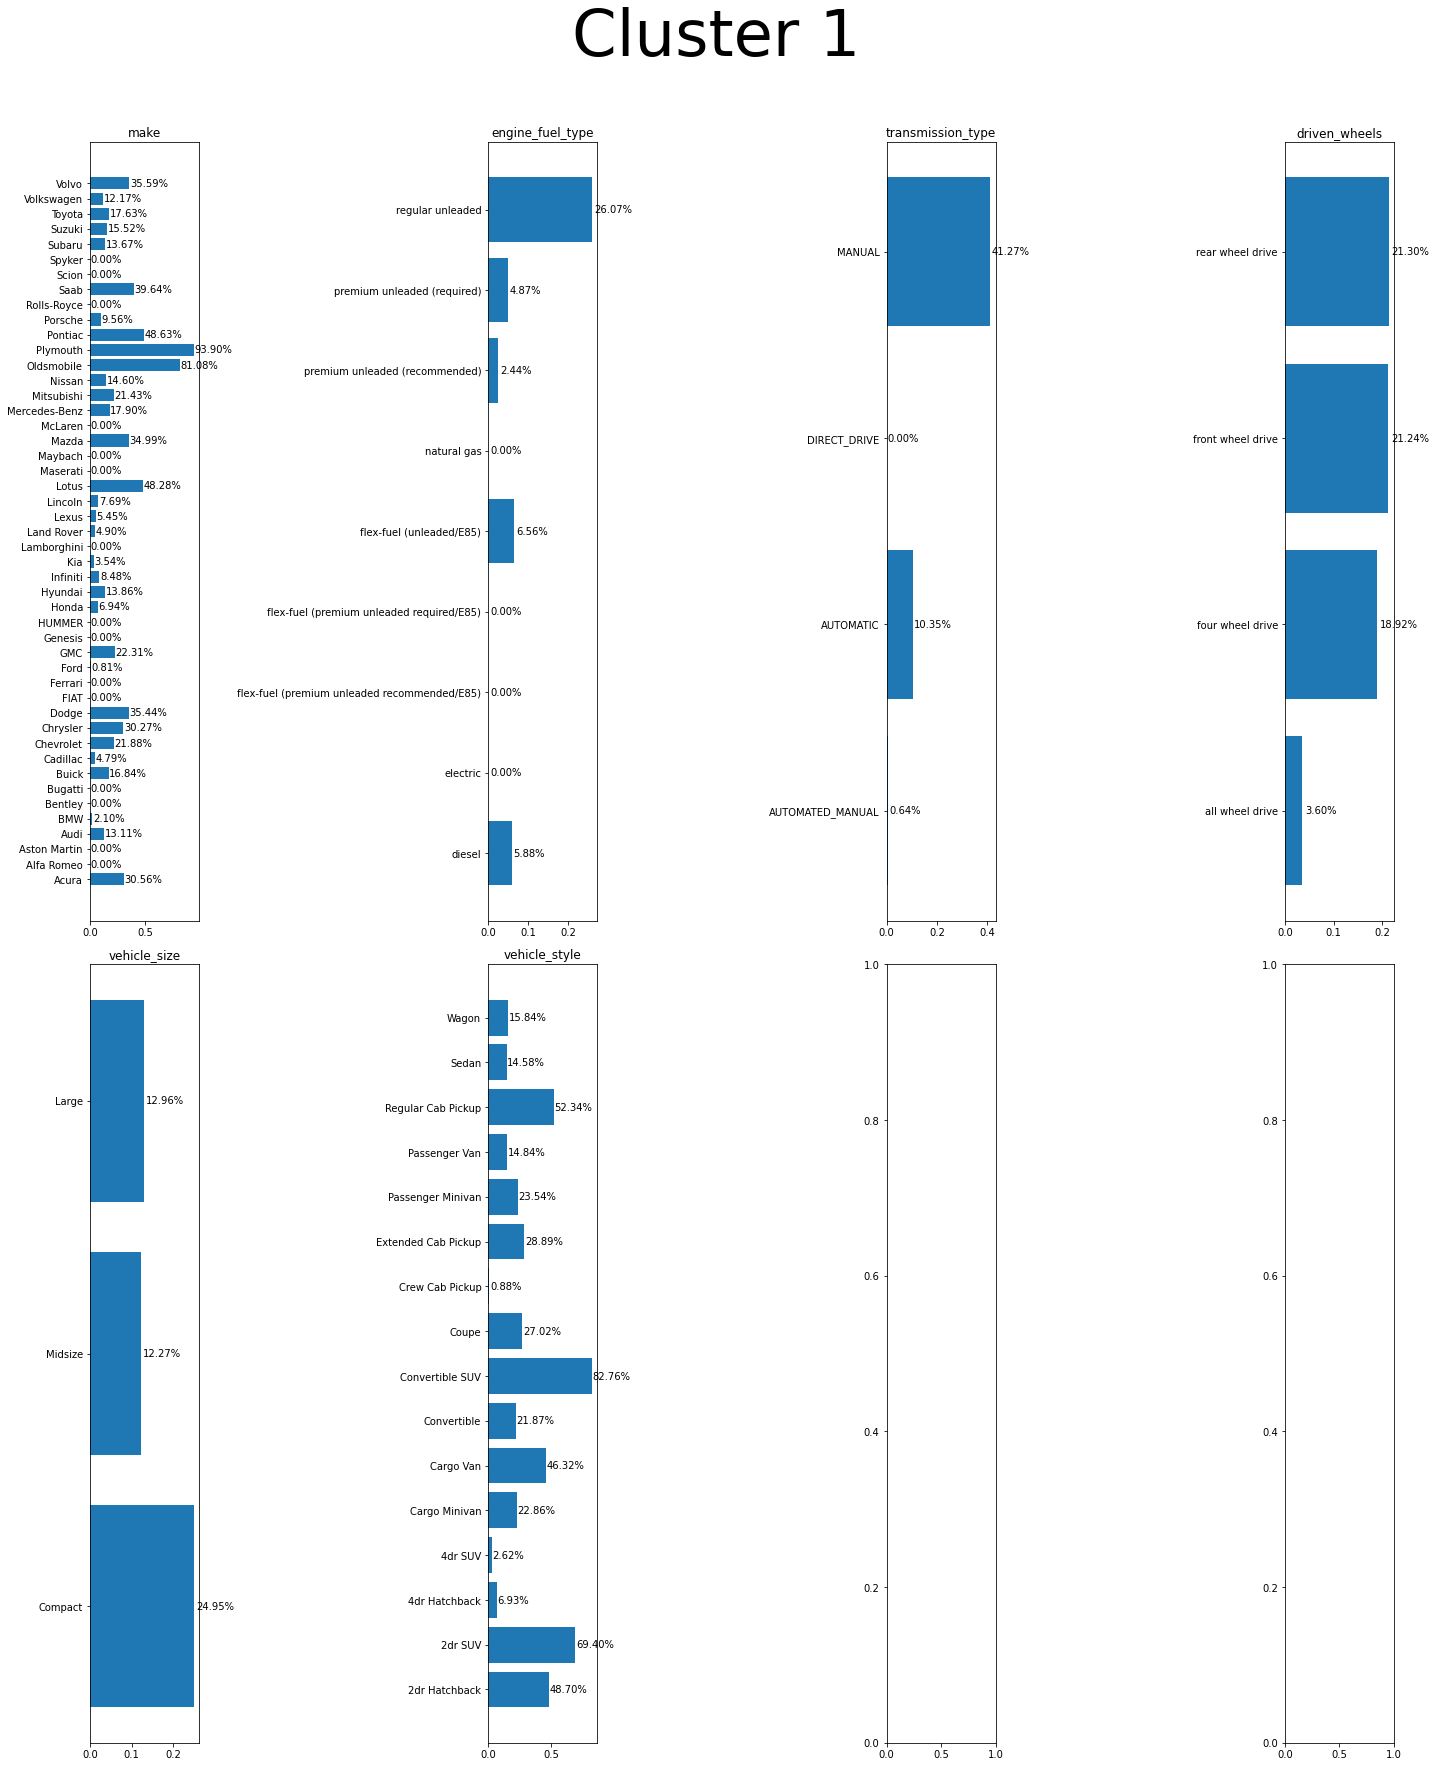

In [ ]:
plot_kprototypes_cat(0)

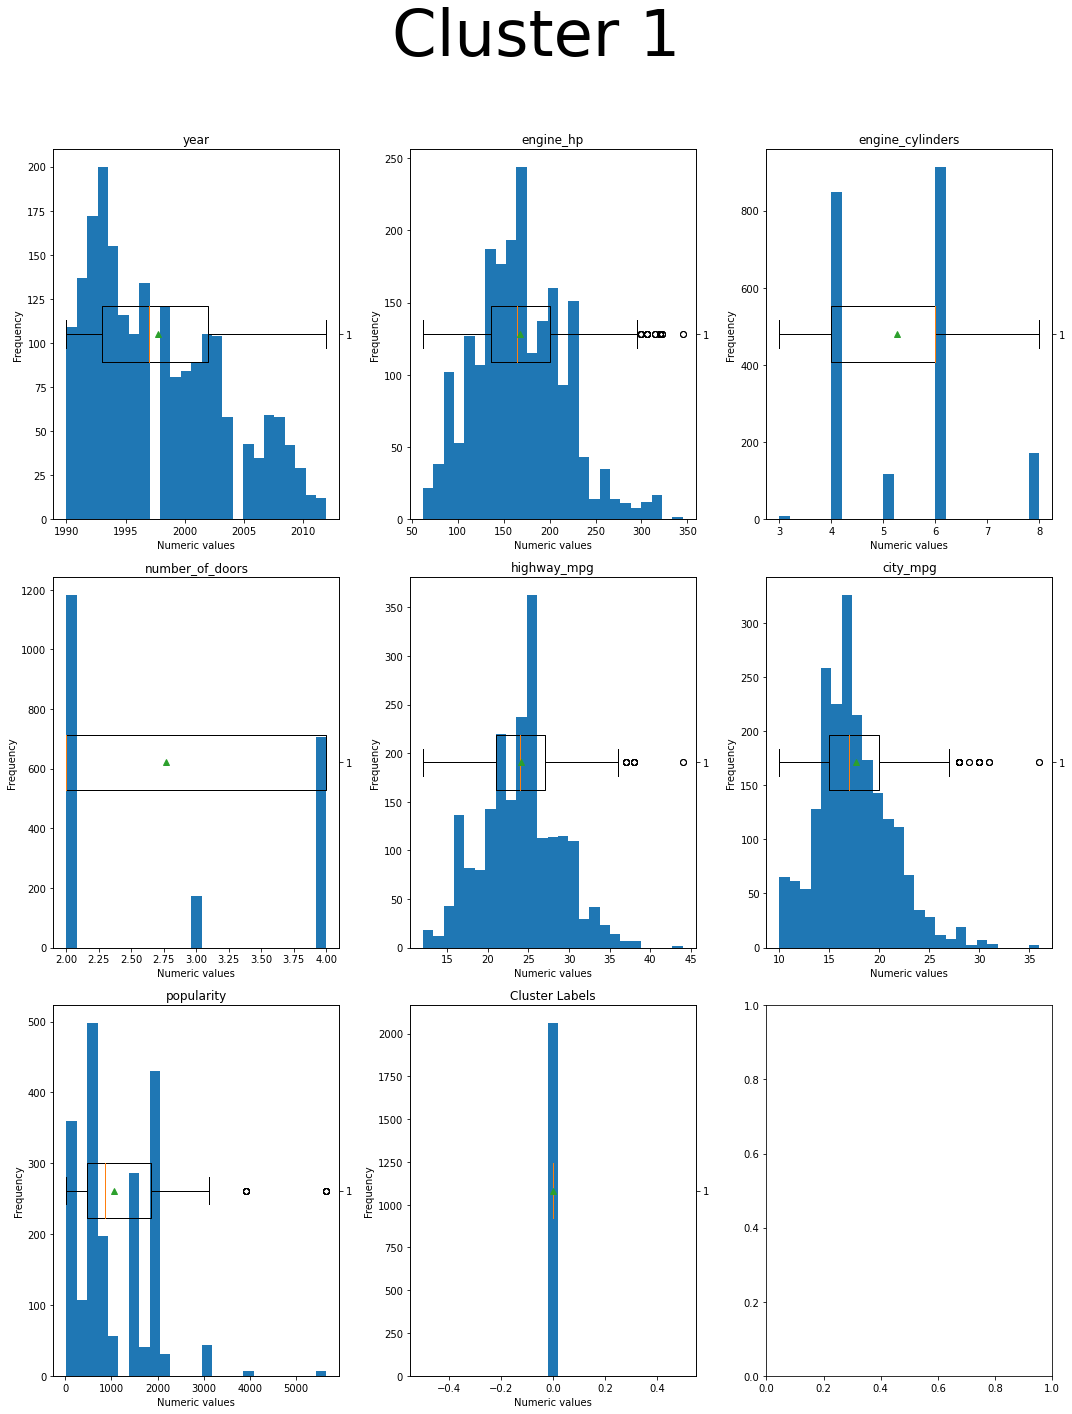

In [ ]:
plot_kprototypes_num(0)

### Cluster 2

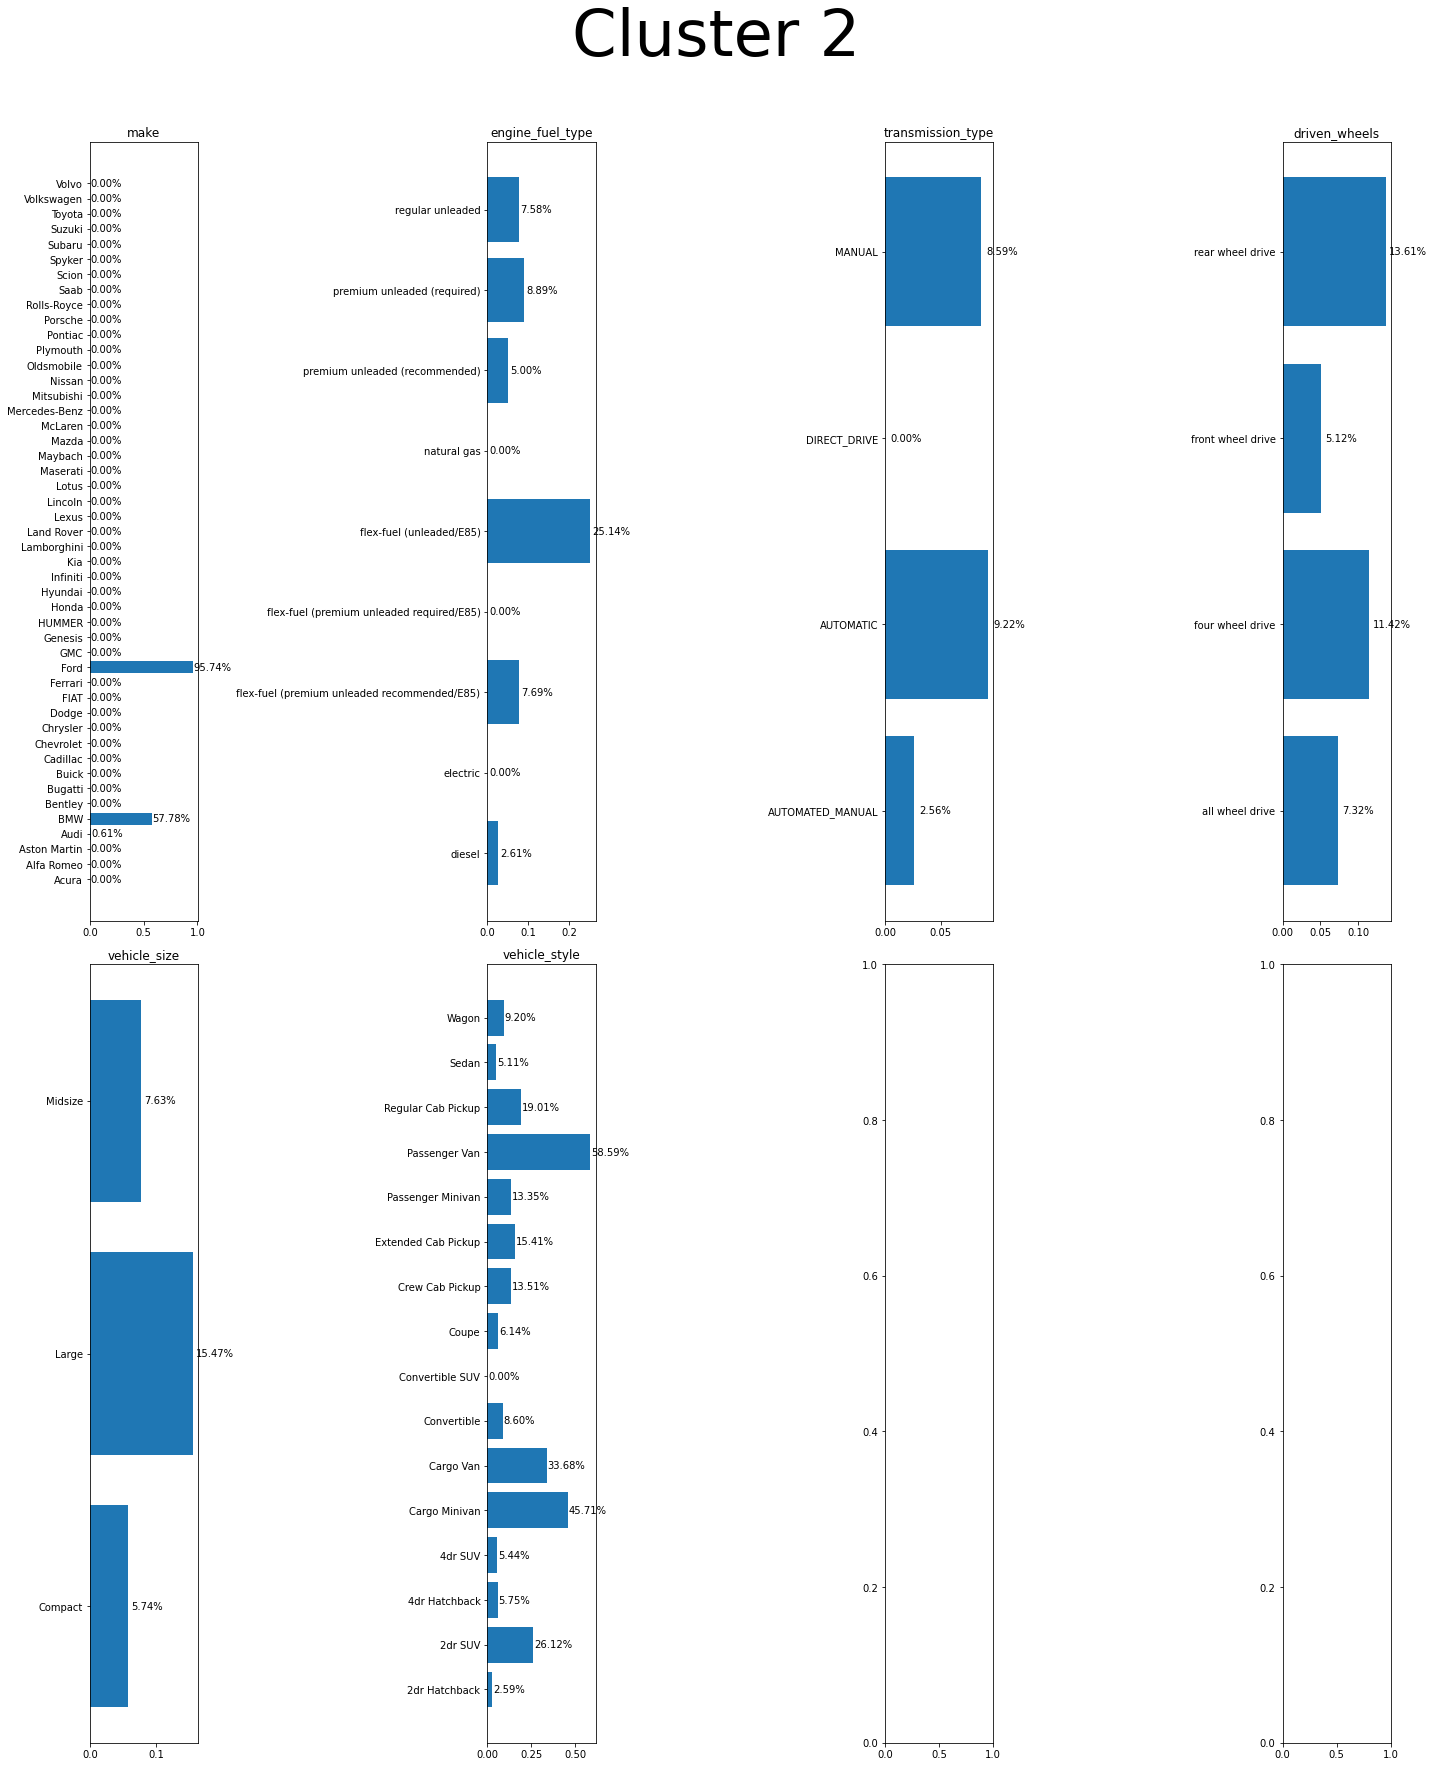

In [ ]:
plot_kprototypes_cat(1)

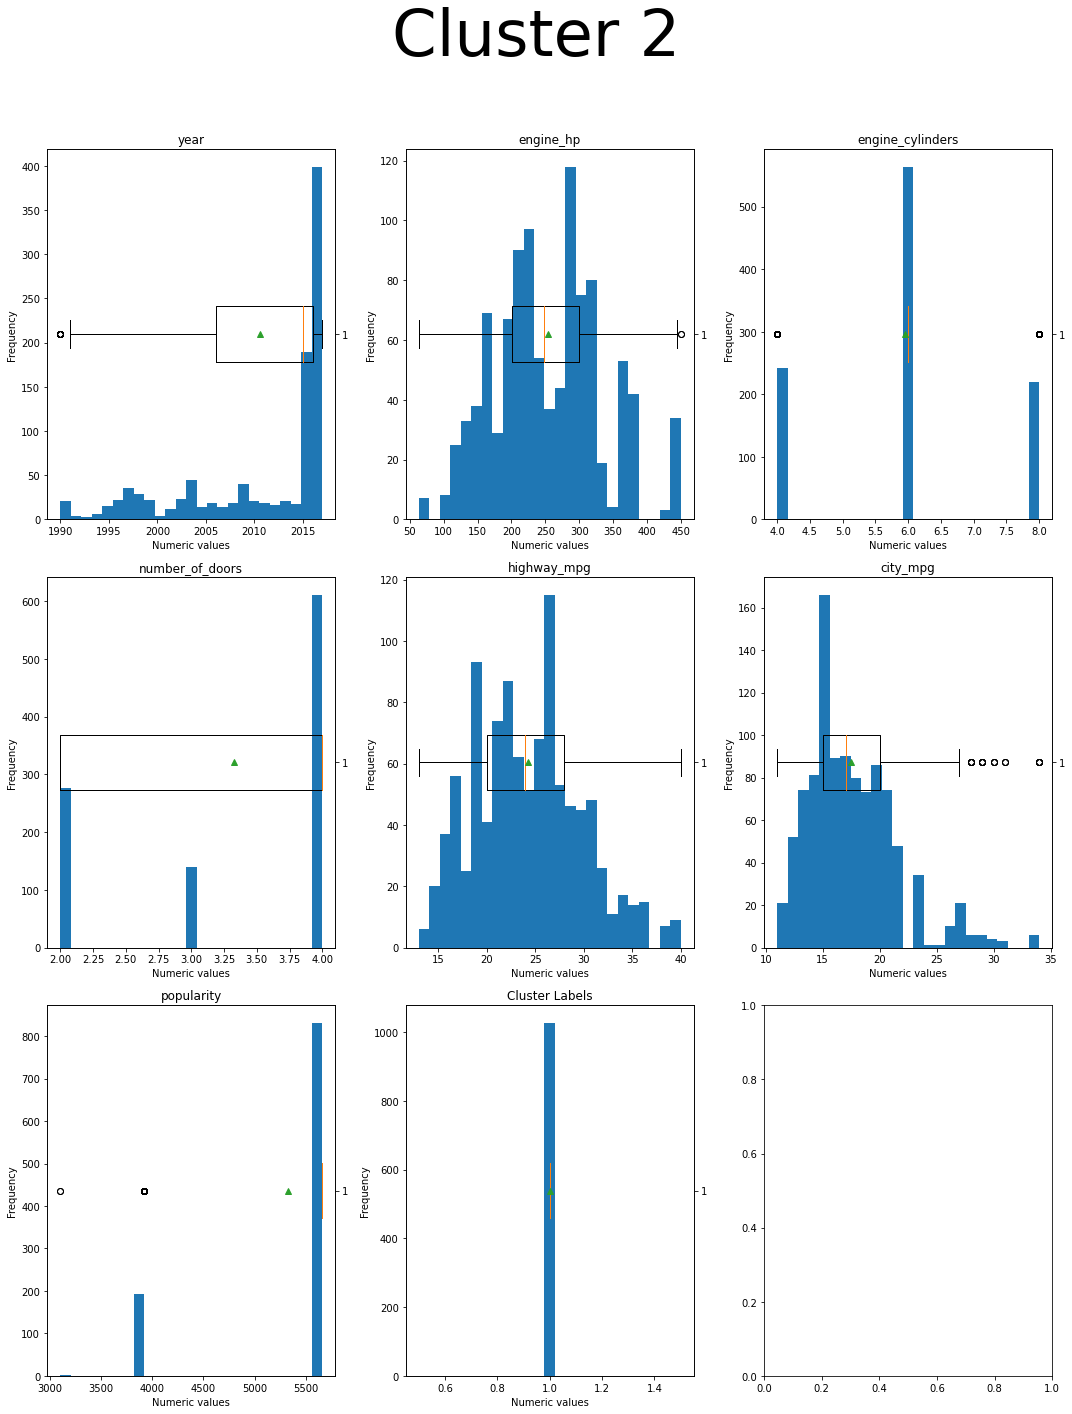

In [ ]:
plot_kprototypes_num(1)

### Cluster 3

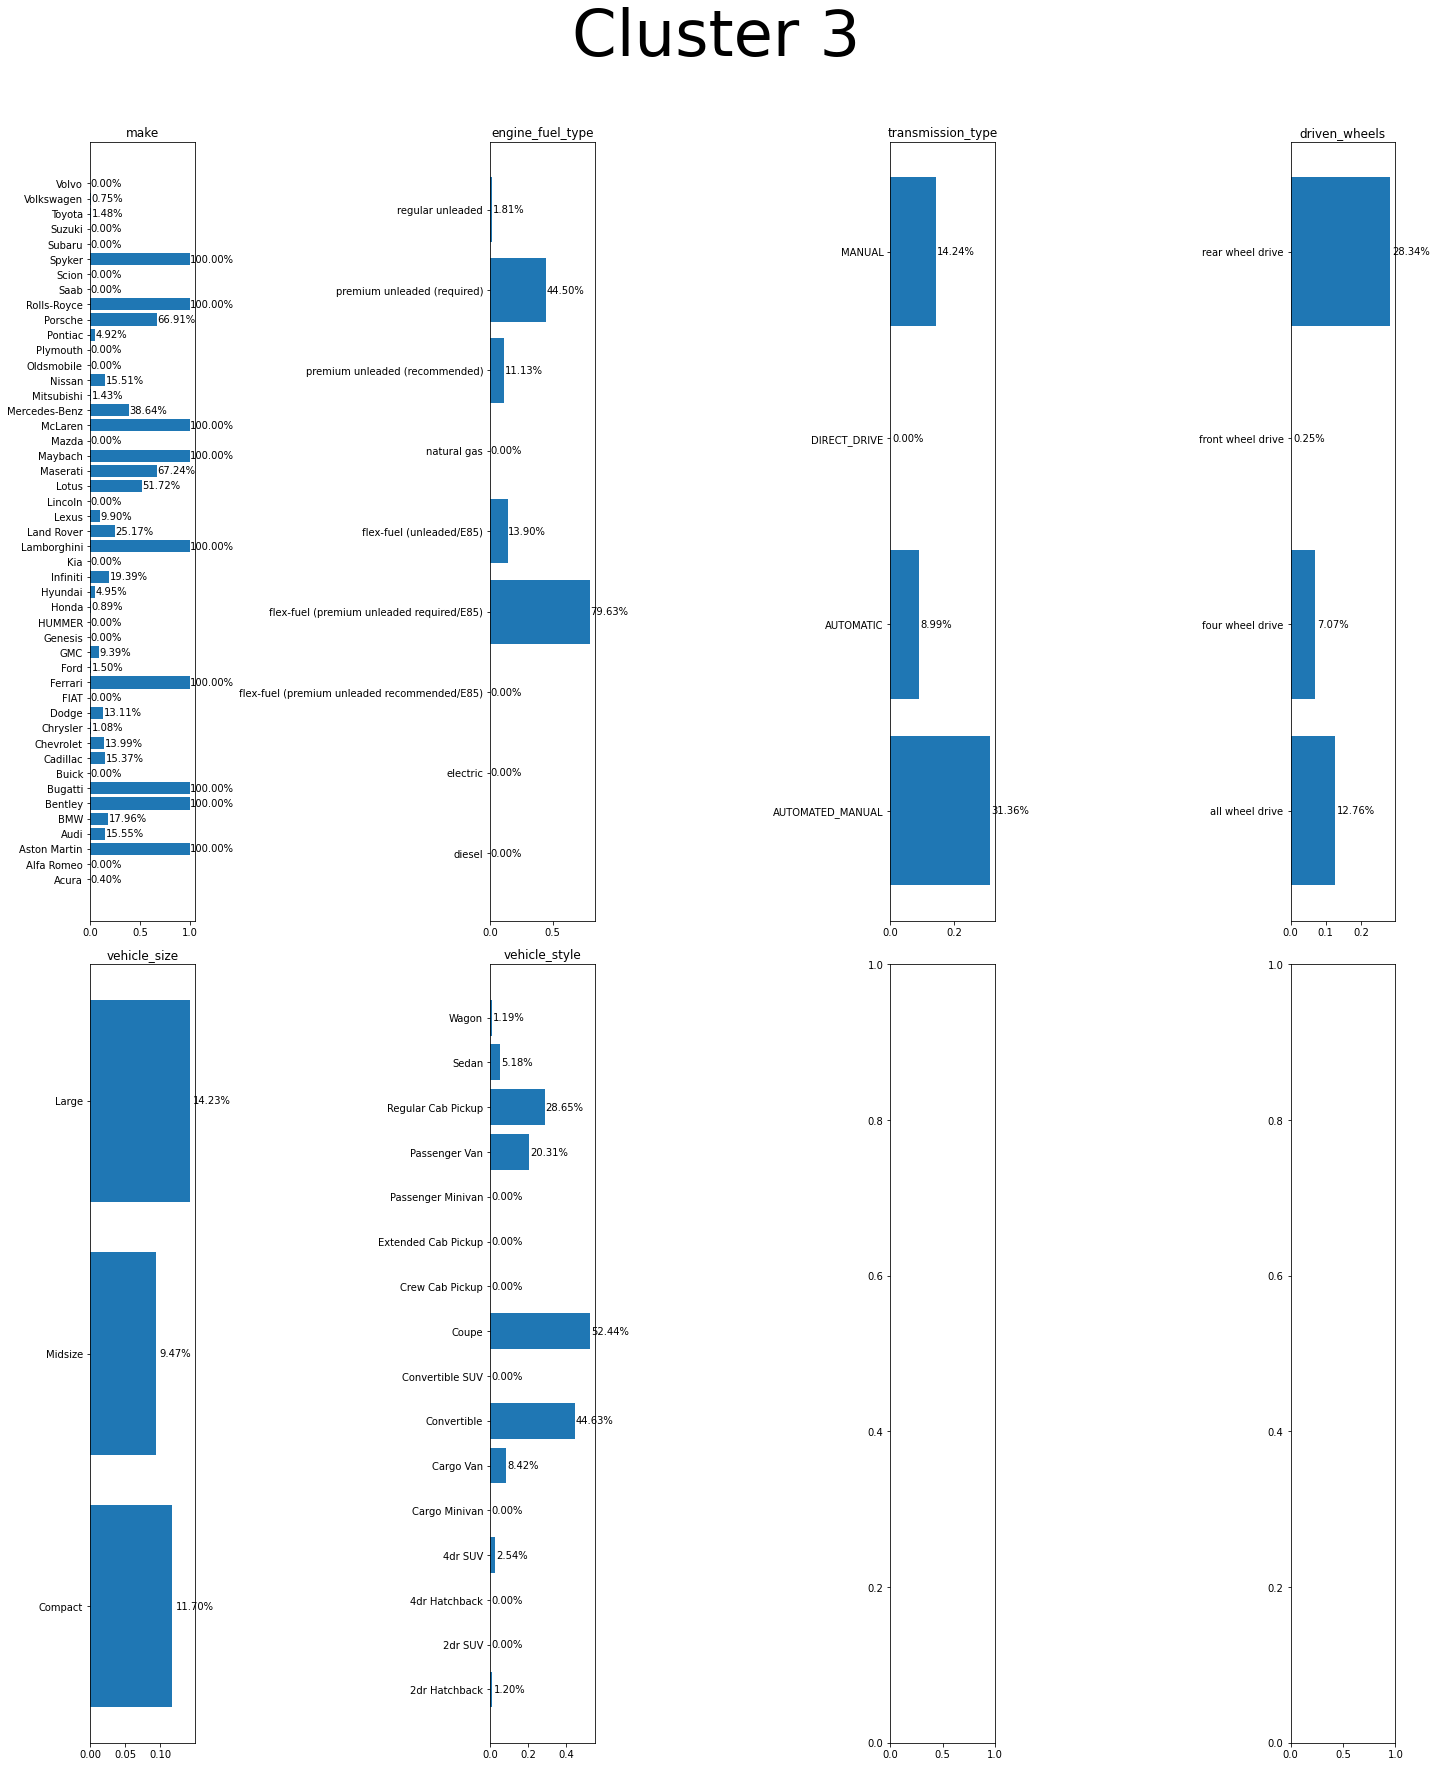

In [ ]:
plot_kprototypes_cat(2)

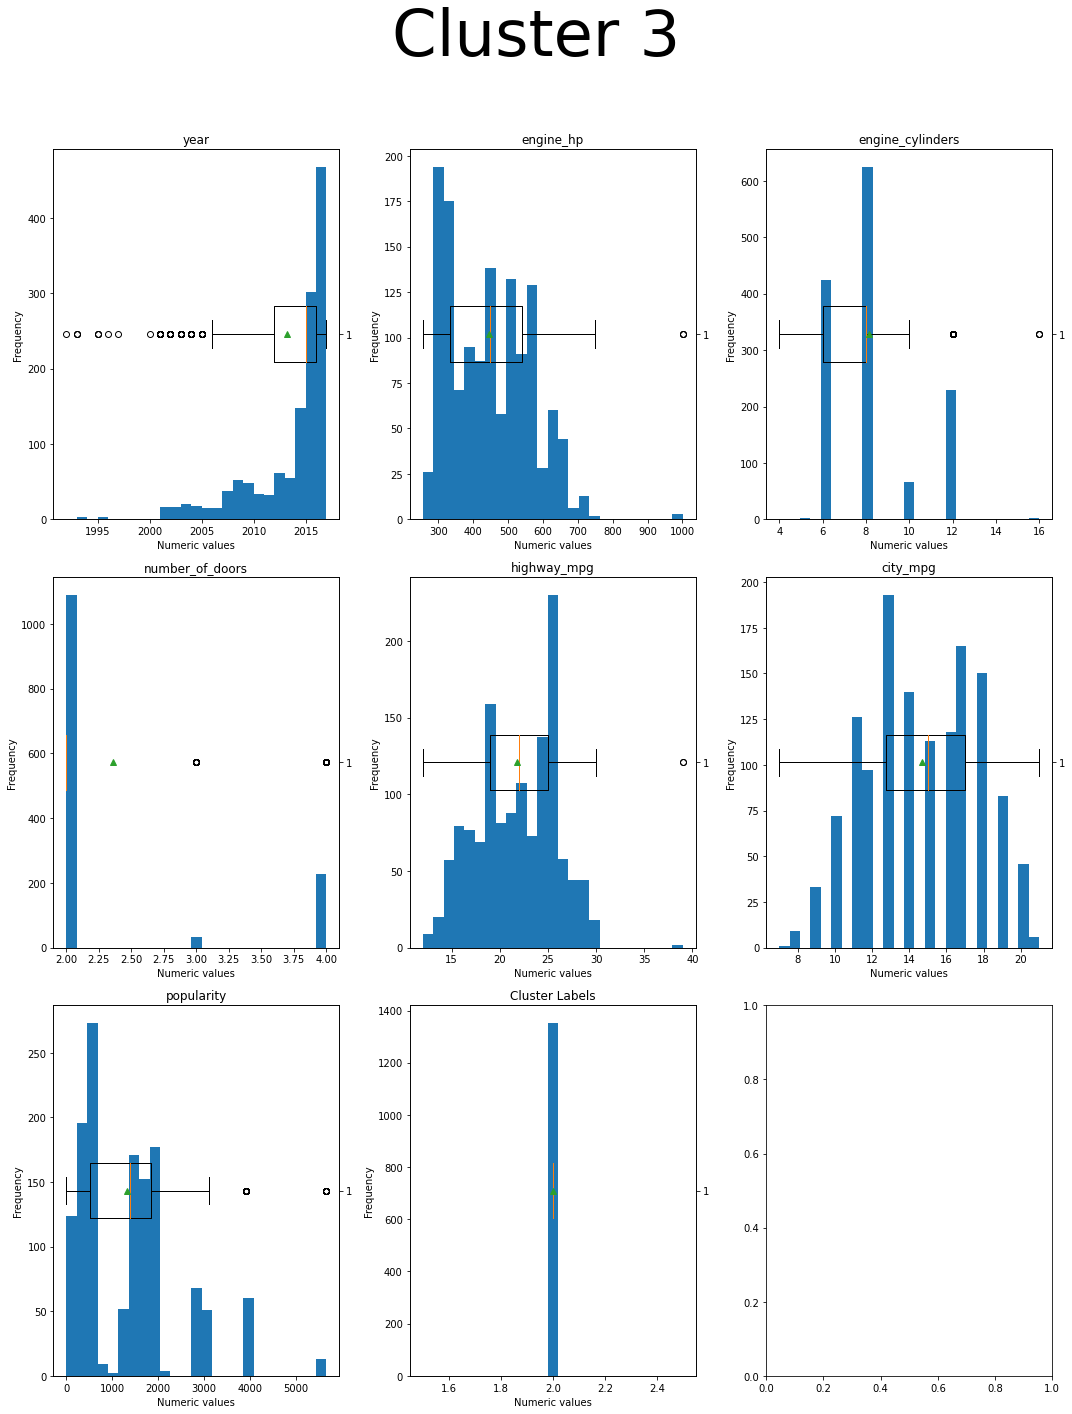

In [ ]:
plot_kprototypes_num(2)

### Cluster 4

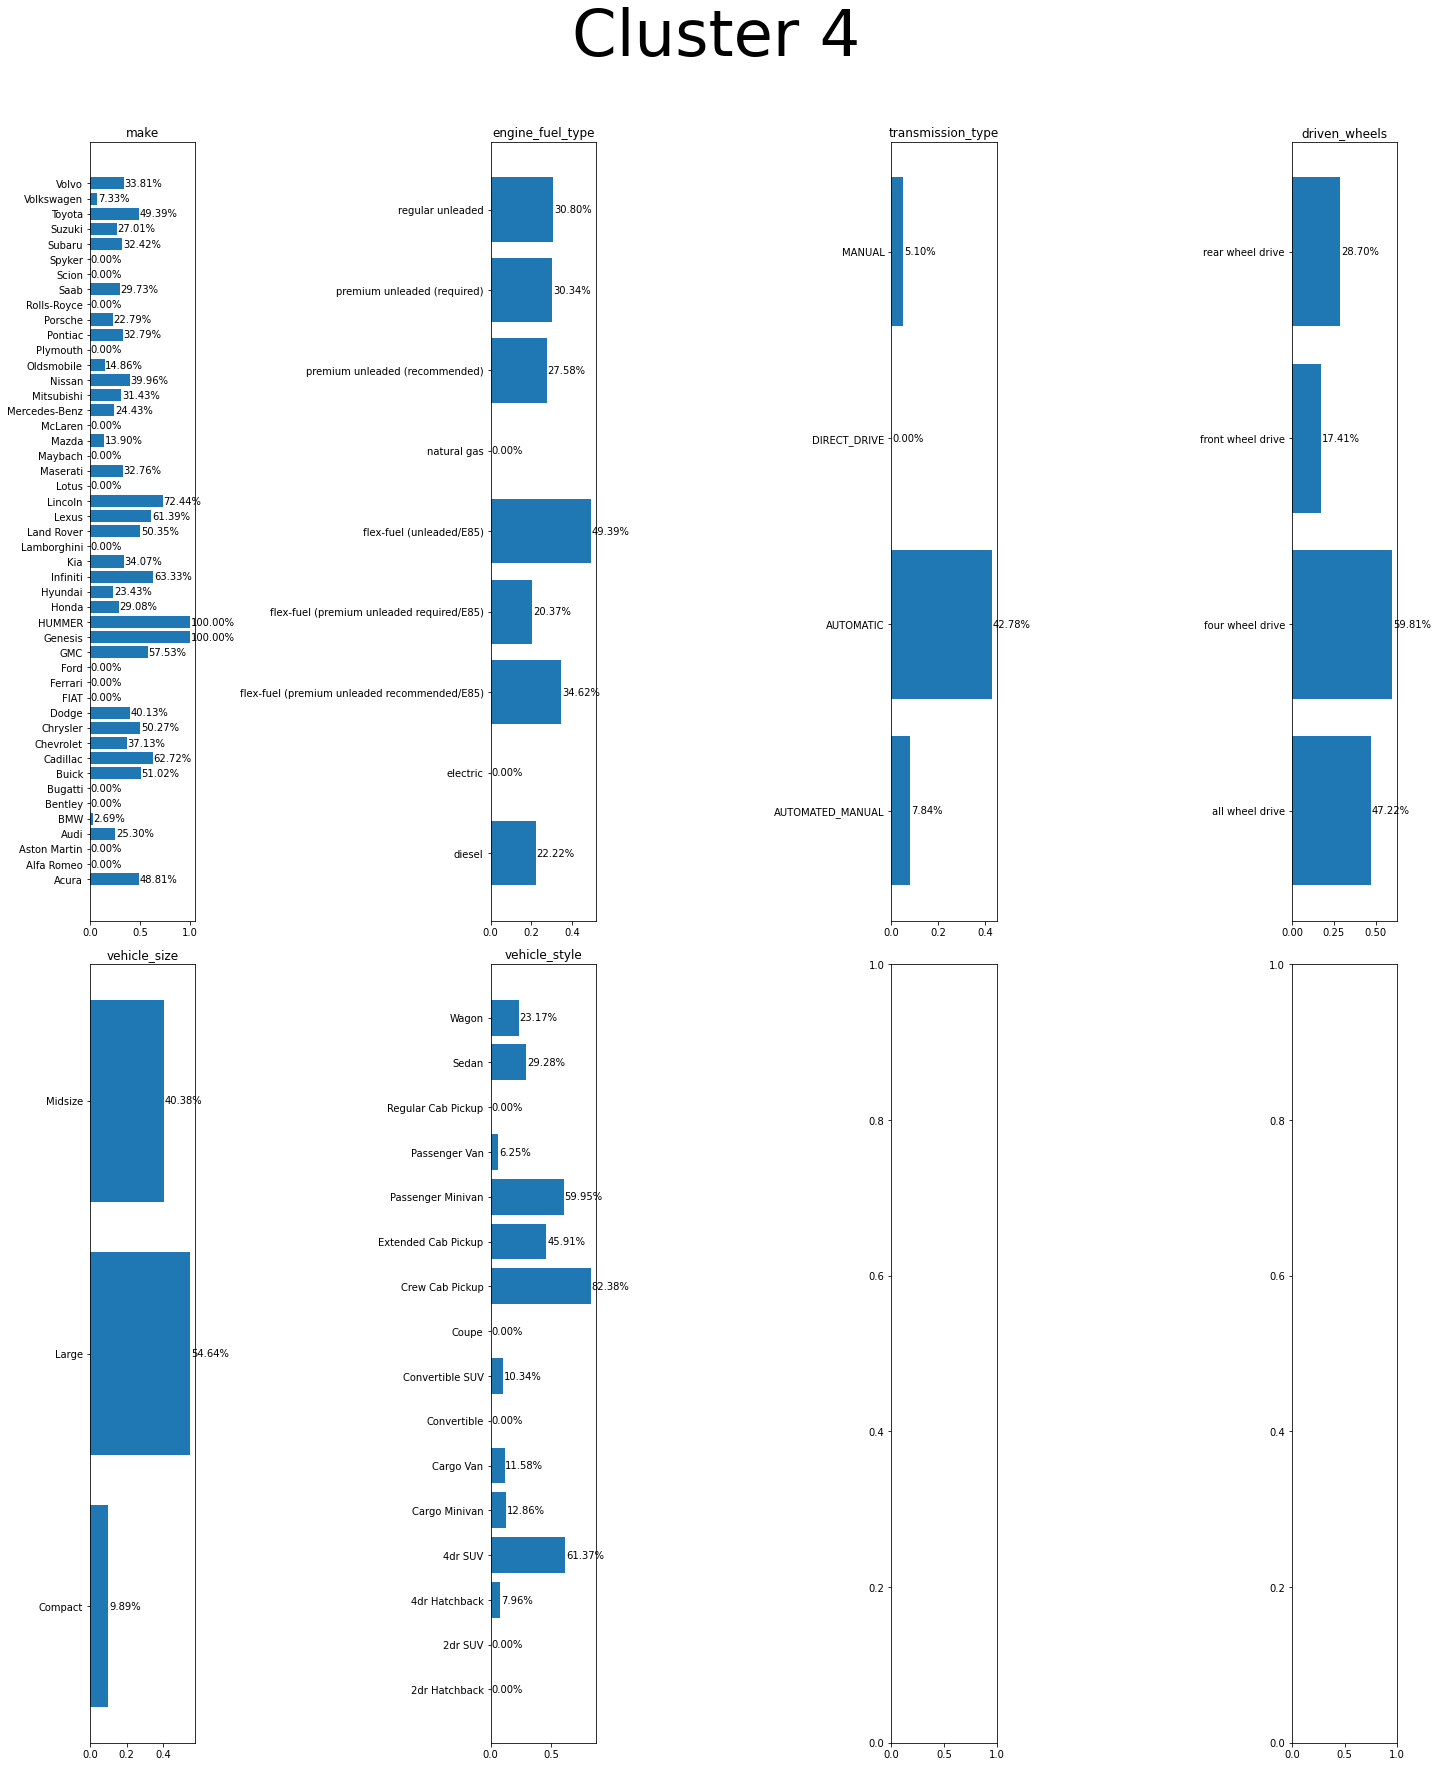

In [ ]:
plot_kprototypes_cat(3)

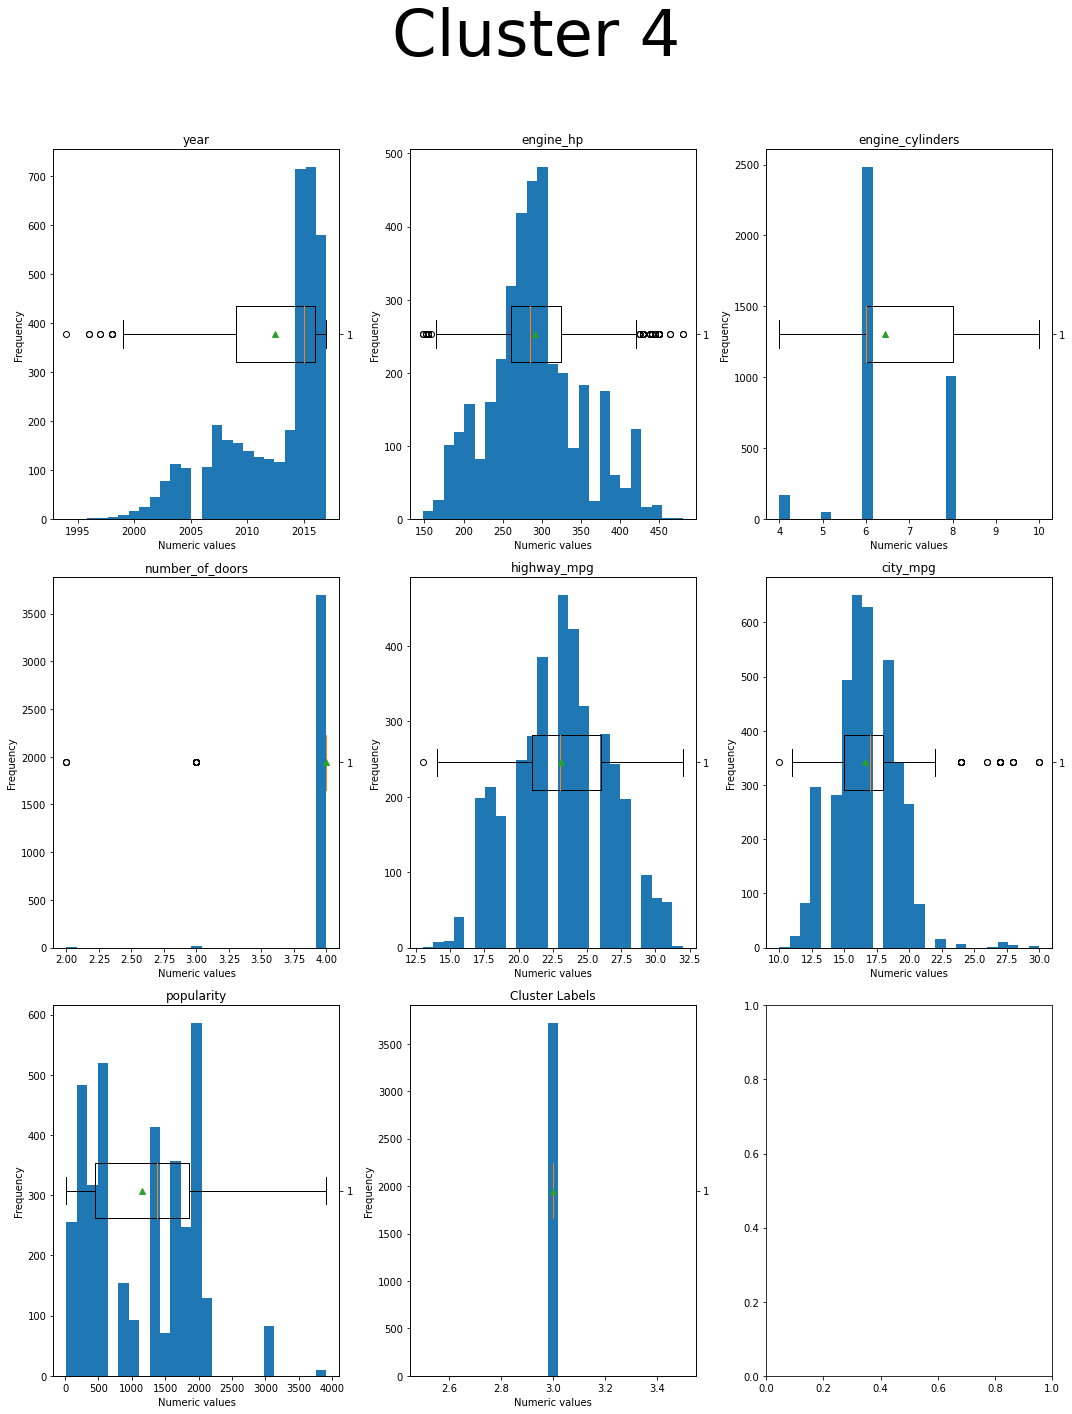

In [ ]:
plot_kprototypes_num(3)

### Cluster 5

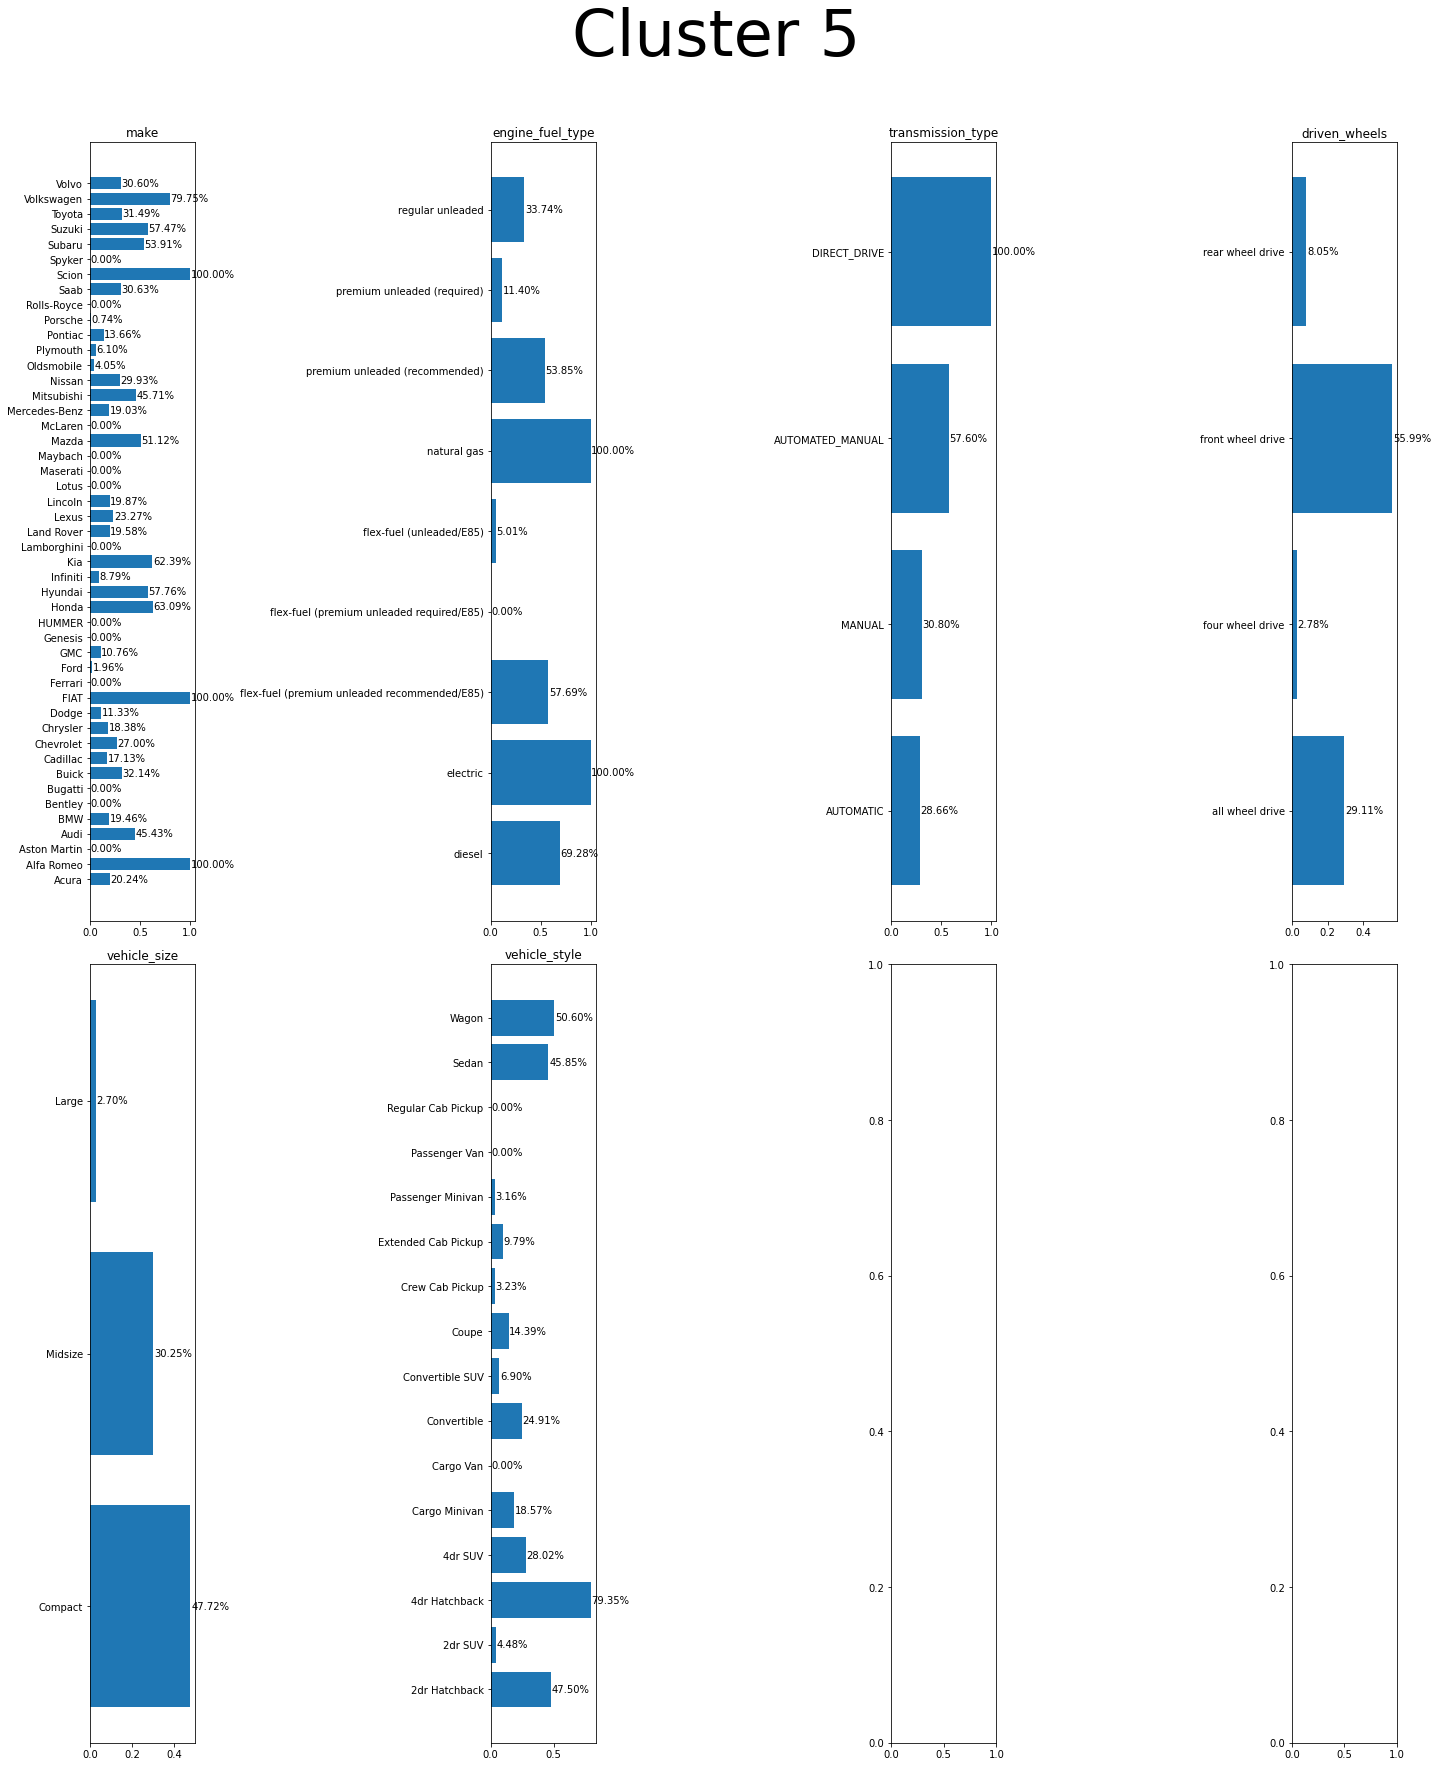

In [ ]:
plot_kprototypes_cat(4)

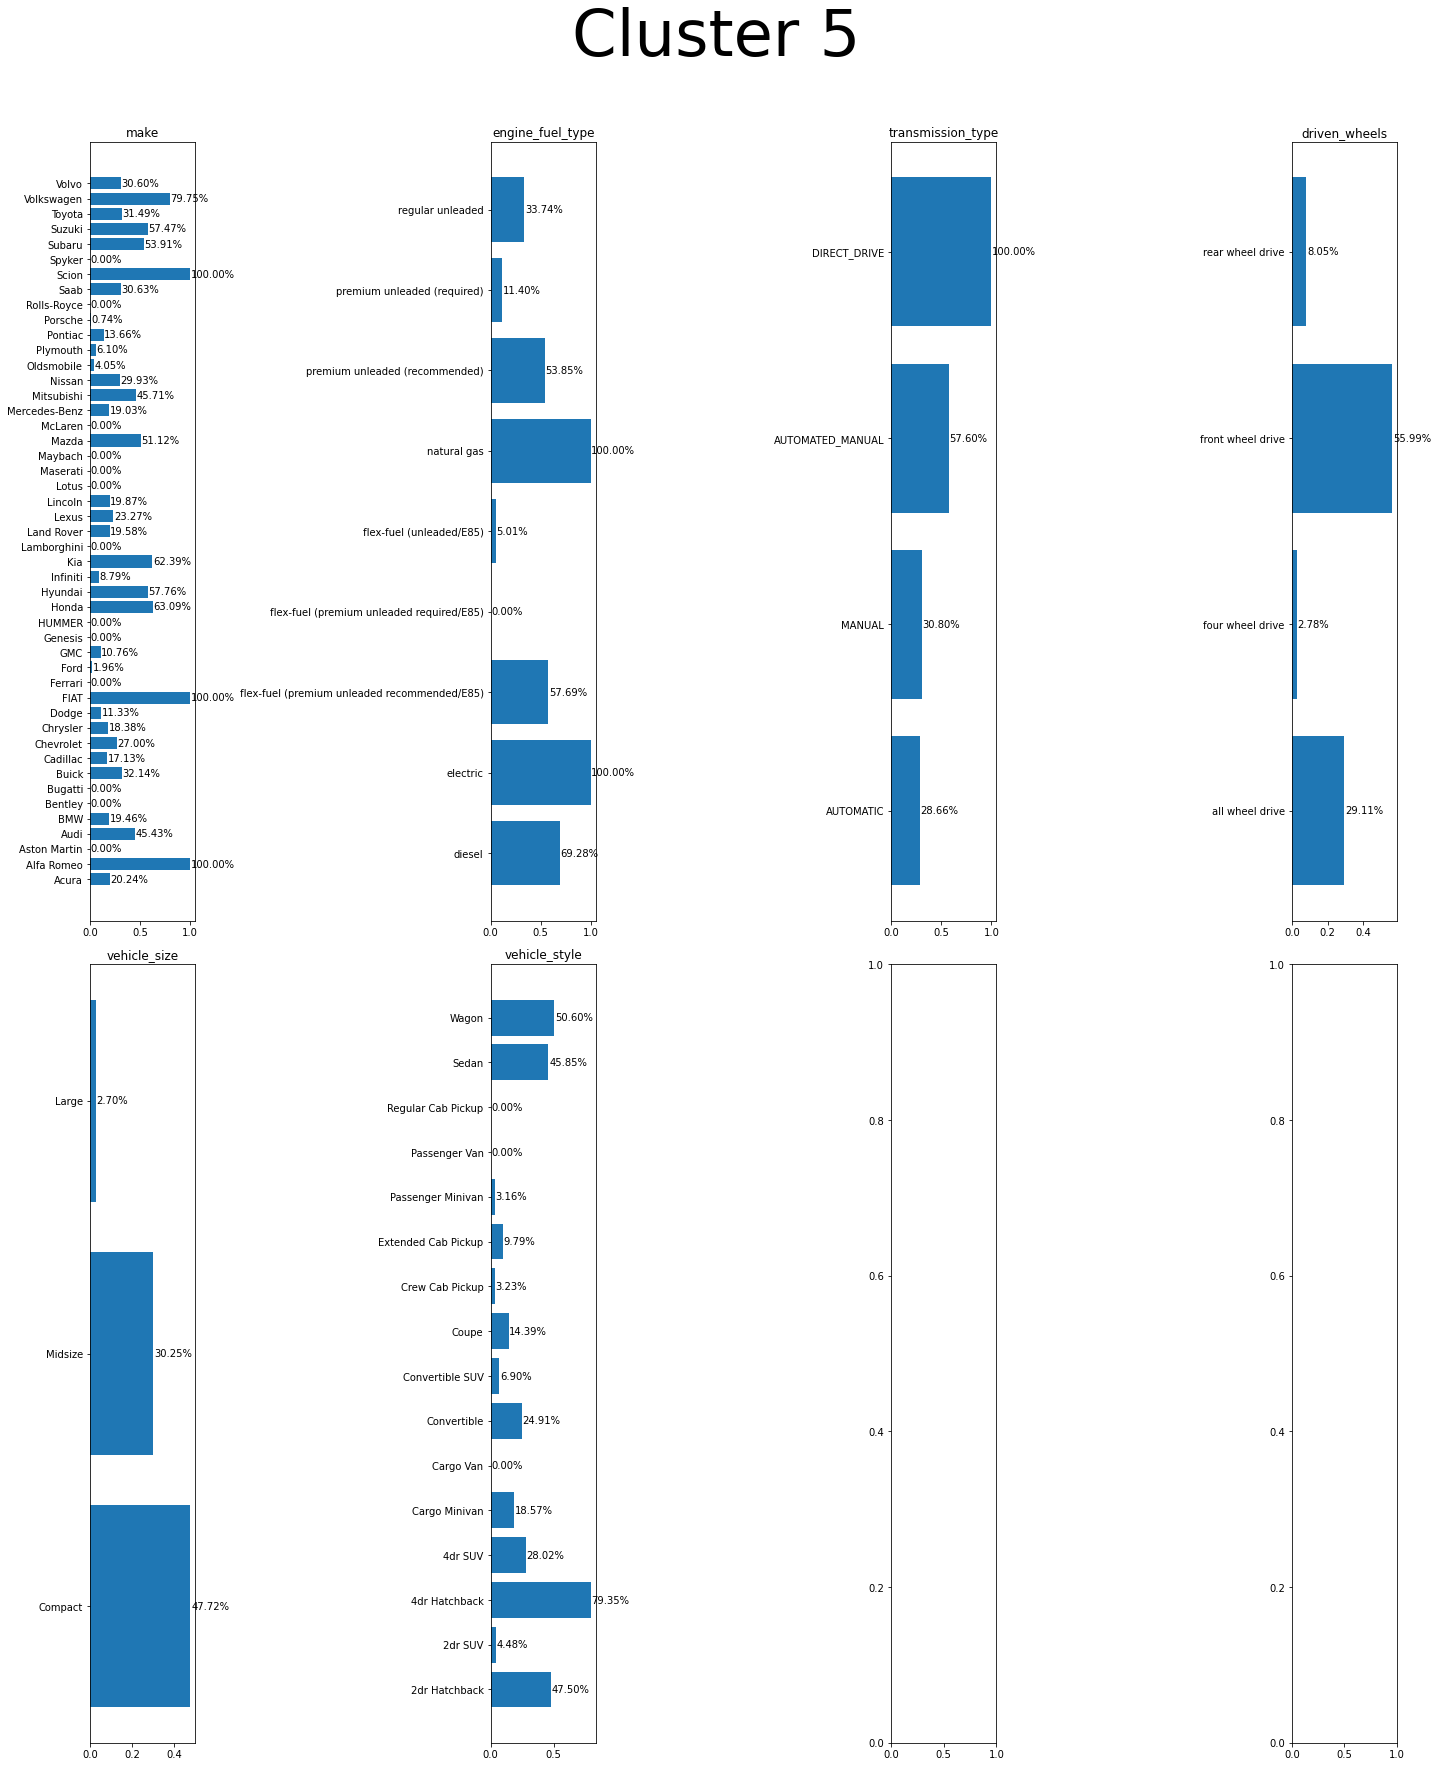

In [ ]:
plot_kprototypes_cat(4)

# Feature Engineering

By manually inspecting what the data points assigned to each cluster contains we see that the data points with a certain make (and some other categorical value) are heavily assigned to the same cluster.

By this realisation we came up with an arbitrary ‘70%-rule’. To understand the rule we give the reader an example of the use of the rule:
If there are 100 data points with the make McLaren and 100 with the make Aston Martins in the dataset, and more than 70 of the McLarens and more than 70 of the Aston Martins has been assigned to cluster X we now give these data points a new make called ‘Luxury’. This results in a dimensionality reduction by feature engineering. This can be seen as dimensionality reduction because we use One Hot Encoding that will turn categorical values into separate features.


In [ ]:
# Define a dictionary of mappings
make_mappings = {
    'Plymouth': 'American',
    'Oldsmobile': 'American',
    'Aston Martin': 'Luxury',
    'Bentley': 'Luxury',
    'Bugatti': 'Luxury',
    'Ferrari': 'Luxury',
    'Lamborghini': 'Luxury',
    'Maybach': 'Luxury',
    'McLaren': 'Luxury',
    'Rolls-Royce': 'Luxury',
    'Spyker': 'Luxury',
    'HUMMER': 'Big Cars',
    'Genesis': 'Big Cars',
    'Lincoln': 'Big Cars',
    'Alfa Romeo': 'European',
    'FIAT': 'European',
    'Scion': 'European',
    'Volkswagen': 'European'
}

fuel_type_mappings = {
    'Electric': 'OTHER',
    'Natural Gas': 'OTHER'
}

vehicle_style_mappings = {
    '2dr SUV': 'SUV',
    'Convertible SUV': 'SUV'
}

# Apply the make mappings
for old_value, new_value in make_mappings.items():
    df.loc[df['make'] == old_value, 'make'] = new_value

# Apply the fuel type mappings
for old_value, new_value in fuel_type_mappings.items():
    df.loc[df['engine_fuel_type'] == old_value, 'engine_fuel_type'] = new_value

# Apply the vehicle style mappings
for old_value, new_value in vehicle_style_mappings.items():
    df.loc[df['vehicle_style'] == old_value, 'vehicle_style'] = new_value


## PCA



Before applying PCA, it's a good practice to look for correlations between numerical features.

High correlation between features indicates redundancy, meaning that the information contained in one feature is similar to that of another feature. This redundancy can lead to multicollinearity in regression models, which can cause instability in model estimates. PCA can help reduce the dimensionality of the dataset by combining highly correlated features into a single principal component, thus minimizing redundancy and improving model performance.

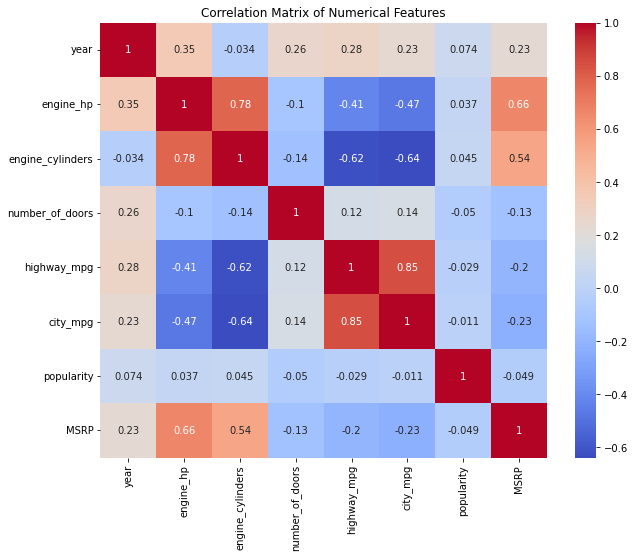

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the numerical features
numerical_df = df.select_dtypes(include='number')

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))  # increase the figsize
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The numerical features seem to be correlated suggesting that PCA should work

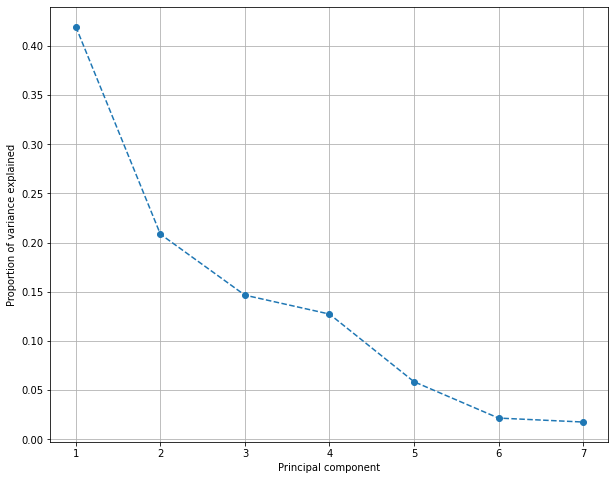

In [ ]:
# Preprocess the dataset
numeric_cols = ['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity']
X = df[numeric_cols]

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a PCA model and calculate the proportion of variance explained
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)
variance = pca.explained_variance_ratio_

# Plot a scree plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))  # increase the figsize
plt.plot(range(1, len(variance)+1), variance, 'o--')
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.grid()
plt.show()

As we can see from the above plot, the first principal component explains most of the variance in the data (over 40%), with the second principal component explaining over 20% of the variance. The remaining principal components explain a smaller proportion of the variance. Therefore, we can conclude that PCA is able to explain a significant amount of the variance in the "Car Features and MSRP" dataset.

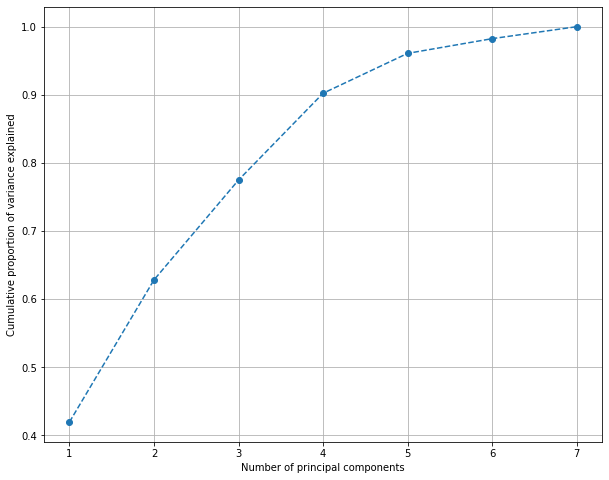

In [ ]:
# Calculate the cumulative proportion of variance explained
cumulative_var = np.cumsum(variance)

# Plot a line graph to visualize the cumulative proportion of variance explained
fig, ax = plt.subplots(figsize=(10, 8))  # increase the figsize
plt.plot(range(1, len(cumulative_var)+1), cumulative_var,'o--')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative proportion of variance explained')
plt.grid()
plt.show()

As we can see from the above plot, 4 principal components seem to explain  around 90% of the variance. Therefore, we might decide to use the 4 principal components as input to downstream analysis, since they capture the majority of the variation in the data.

# Supervised learning

For supervised learning we split our data into a 70-15-15 train-validation-test split. This allows us to train different models with different hyperparameters on 70% of the data. Then test what models perform best on the validation set. The best performing model is then tested on the final test set which gives us our best estimate as to how the model would perform in the real world.

This approach helps to avoid overfitting.

## Without applying a logarithmic transformation

In [ ]:
# Split the data into a training set (70%), a testing set (15%), and an evaluation set (15%)
X = df.drop('MSRP', axis=1)
y = df['MSRP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Separate numerical and categorical features
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# One-hot encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[cat_cols])
X_test_ohe = ohe.transform(X_test[cat_cols])
X_eval_ohe = ohe.transform(X_eval[cat_cols])

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
X_eval_scaled = scaler.transform(X_eval[num_cols])

In [ ]:
# NOTE: Do not run this cell when you want to skip transformation with PCA, instead run the cell below.
# Perform PCA on the numerical features
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_eval_pca = pca.transform(X_eval_scaled)

# Combine the processed numerical and categorical features
X_train_processed = hstack([X_train_pca, X_train_ohe])
X_test_processed = hstack([X_test_pca, X_test_ohe])
X_eval_processed = hstack([X_eval_pca, X_eval_ohe])

In [ ]:
# NOTE: Uncommment this cell when running code without PCA transformation.
# Combine the processed numerical and categorical features
# X_train_processed = hstack([X_train_scaled, X_train_ohe])
# X_test_processed = hstack([X_test_scaled, X_test_ohe])
# X_eval_processed = hstack([X_eval_scaled, X_eval_ohe])

### Random Forest

Employing the evaluation set for determining the optimal parameters for Random Forest Regression (gridsearch)

In [ ]:
# Define the hyperparameters to test
n_estimators_list = [50, 100, 200]
max_depth_list = [None, 10, 20]
min_samples_split_list = [2, 4, 8]
min_samples_leaf_list = [1, 2, 4]

# Initialize a list to store the results
results = []

# Iterate over hyperparameters
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:

                # Train a RandomForestRegressor model
                rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                            random_state=42)
                rf.fit(X_train_processed, y_train)

                # Make predictions on the evaluation set
                y_pred_eval_rf = rf.predict(X_eval_processed)

                # Calculate evaluation metrics
                mse_eval_rf = mean_squared_error(y_eval, y_pred_eval_rf)
                rmse_eval_rf = np.sqrt(mse_eval_rf)
                mae_eval_rf = mean_absolute_error(y_eval, y_pred_eval_rf)
                r2_eval_rf = r2_score(y_eval, y_pred_eval_rf)

                # Store the results in the list
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'MSE': mse_eval_rf,
                    'RMSE': rmse_eval_rf,
                    'MAE': mae_eval_rf,
                    'R2': r2_eval_rf
                })

# Sort the results based on RMSE and R^2
results_sorted = sorted(results, key=lambda x: (x['RMSE'], -x['R2']))

# Print the best parameters and metrics
best_params = results_sorted[0]
print(f"Best parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']}, min_samples_leaf={best_params['min_samples_leaf']}")
print(f"MSE: {best_params['MSE']:.4f}")
print(f"RMSE: {best_params['RMSE']:.4f}")
print(f"MAE: {best_params['MAE']:.4f}")
print(f"R^2: {best_params['R2']:.4f}")

Based on the results from the gridsearch above, the best paramteres are n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1 for Random Forest Regression.

In [ ]:
# Train a RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf.fit(X_train_processed, y_train)

# Make predictions on the evaluation set
y_pred_eval_rf = rf.predict(X_eval_processed)

# Calculate the RMSE for the evaluation set
rmse_eval_rf = mean_squared_error(y_eval, y_pred_eval_rf, squared=False)

# Calculate the R2 score for the evaluation set
r2_eval_rf = r2_score(y_eval, y_pred_eval_rf)

# Print the RMSE and R2 scores for the evaluation set
print("RMSE for the evaluation set: {:.4f}".format(rmse_eval_rf))
print("R2 score for the evaluation set: {:.4f}".format(r2_eval_rf))

RMSE for the evaluation set: 9398.8073
R2 score for the evaluation set: 0.9605


### Lasso

Employing the evaluation set for determining the optimal parameters for Lasso

In [ ]:
from sklearn.linear_model import Lasso

# Define the values of alpha to test
alpha_list = [0.01, 0.1, 1, 10, 100]

# Initialize a dictionary to store the results
results = {}

# Define the weights for RMSE and R^2
a = 0.5
b = 0.5

# Iterate over alpha values
for alpha in alpha_list:

    # Train a Lasso model
    L = Lasso(alpha=alpha)
    L.fit(X_train_processed, y_train)

    # Make predictions on the evaluation set
    y_pred_eval_L = L.predict(X_eval_processed)

    # Calculate evaluation metrics
    mse_eval_L = mean_squared_error(y_eval, y_pred_eval_L)
    rmse_eval_L = np.sqrt(mse_eval_L)
    mae_eval_L = mean_absolute_error(y_eval, y_pred_eval_L)
    r2_eval_L = r2_score(y_eval, y_pred_eval_L)

    # Calculate the combined score
    score = a * r2_eval_L - b * rmse_eval_L

    # Store the results in the dictionary
    results[alpha] = {
        'MSE': mse_eval_L,
        'RMSE': rmse_eval_L,
        'MAE': mae_eval_L,
        'R2': r2_eval_L,
        'Score': score
    }

# Sort the results by the combined score
sorted_results = sorted(results, key=lambda x: -results[x]['Score'])

# Get the best hyperparameters
best_alpha = sorted_results[0]
best_rmse = results[best_alpha]['RMSE']
best_r2 = results[best_alpha]['R2']
print(f"Best alpha: {best_alpha}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R^2: {best_r2:.4f}")

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1383015053293.461, tolerance: 3124729815.841854
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1168452563598.2715, tolerance: 3124729815.841854
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 202108029071.23633, tolerance: 3124729815.841854
  model = cd_fast.sparse_enet_coordinate_descent(


Best alpha: 1
Best RMSE: 18257.2082
Best R^2: 0.8396


### Linear Regression

In [ ]:
# Train a Linear Regression model
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

# Make predictions on the evaluation set
y_pred_eval_lr = lr.predict(X_eval_processed)

# Calculate the RMSE for the evaluation set
rmse_eval_lr = mean_squared_error(y_eval, y_pred_eval_lr, squared=False)

# Calculate the R2 score for the evaluation set
r2_eval_lr = r2_score(y_eval, y_pred_eval_lr)

# Print the RMSE and R2 scores for the evaluation set
print("RMSE for the evaluation set (Linear Regression): {:.4f}".format(rmse_eval_lr))
print("R2 score for the evaluation set (Linear Regression): {:.4f}".format(r2_eval_lr))

RMSE for the evaluation set (Linear Regression): 18257.2789
R2 score for the evaluation set (Linear Regression): 0.8396


## Applying a logarithmic transformation

After feedback from our supervisor we also tried to predict the log price.

In [ ]:
# Split the data into a training set (70%), a testing set (15%), and an evaluation set (15%)
X = df.drop('MSRP', axis=1)
y = np.log(df['MSRP'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Separate numerical and categorical features
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# One-hot encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[cat_cols])
X_test_ohe = ohe.transform(X_test[cat_cols])
X_eval_ohe = ohe.transform(X_eval[cat_cols])

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
X_eval_scaled = scaler.transform(X_eval[num_cols])

In [ ]:
# NOTE: Do not run this cell when you want to skip transformation with PCA, instead run the cell below.
# Perform PCA on the numerical features
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_eval_pca = pca.transform(X_eval_scaled)

# Combine the processed numerical and categorical features
X_train_processed = hstack([X_train_pca, X_train_ohe])
X_test_processed = hstack([X_test_pca, X_test_ohe])
X_eval_processed = hstack([X_eval_pca, X_eval_ohe])

In [ ]:
# NOTE: Uncommment this cell when running code without PCA transformation.
# Combine the processed numerical and categorical features
# X_train_processed = hstack([X_train_scaled, X_train_ohe])
# X_test_processed = hstack([X_test_scaled, X_test_ohe])
# X_eval_processed = hstack([X_eval_scaled, X_eval_ohe])

### Random Forest Regression

Employing the evaluation set for determining the optimal parameters for Random Forest Regression.

In [ ]:
# Define the hyperparameters to test
n_estimators_list = [50, 100, 200]
max_depth_list = [None, 10, 20]
min_samples_split_list = [2, 4, 8]
min_samples_leaf_list = [1, 2, 4]

# Initialize a list to store the results
results = []

# Iterate over hyperparameters
for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:

                # Train a RandomForestRegressor model
                rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                            random_state=42)
                rf.fit(X_train_processed, y_train)

                # Make predictions on the evaluation set
                y_pred_eval_rf = rf.predict(X_eval_processed)

                # Calculate evaluation metrics
                mse_eval_rf = mean_squared_error(y_eval, y_pred_eval_rf)
                rmse_eval_rf = np.sqrt(mse_eval_rf)
                mae_eval_rf = mean_absolute_error(y_eval, y_pred_eval_rf)
                r2_eval_rf = r2_score(y_eval, y_pred_eval_rf)

                # Store the results in the list
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'MSE': mse_eval_rf,
                    'RMSE': rmse_eval_rf,
                    'MAE': mae_eval_rf,
                    'R2': r2_eval_rf
                })

# Sort the results based on RMSE and R^2
results_sorted = sorted(results, key=lambda x: (x['RMSE'], -x['R2']))

# Print the best parameters and metrics
best_params = results_sorted[0]
print(f"Best parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']}, min_samples_leaf={best_params['min_samples_leaf']}")
print(f"MSE: {best_params['MSE']:.4f}")
print(f"RMSE: {best_params['RMSE']:.4f}")
print(f"MAE: {best_params['MAE']:.4f}")
print(f"R^2: {best_params['R2']:.4f}")

Best parameters: n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1
MSE: 0.0452
RMSE: 0.2126
MAE: 0.1055
R^2: 0.9640


Based on these results from the gridsearch above, the best parameters are n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1 for Random Forest Regression

In [ ]:
# Train a RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf.fit(X_train_processed, y_train)

# Make predictions on the evaluation set
y_pred_eval_rf = rf.predict(X_eval_processed)

# Calculate the RMSE for the evaluation set
rmse_eval_rf = mean_squared_error(y_eval, y_pred_eval_rf, squared=False)

# Calculate the R2 score for the evaluation set
r2_eval_rf = r2_score(y_eval, y_pred_eval_rf)

# Print the RMSE and R2 scores for the evaluation set
print("RMSE for the evaluation set: {:.4f}".format(rmse_eval_rf))
print("R2 score for the evaluation set: {:.4f}".format(r2_eval_rf))

RMSE for the evaluation set: 0.2135
R2 score for the evaluation set: 0.9636


### Lasso

In [ ]:
# Define the values of alpha to test
alpha_list = [0.01, 0.1, 1, 10, 100]

# Initialize a dictionary to store the results
results = {}

# Define the weights for RMSE and R^2
a = 0.5
b = 0.5

# Iterate over alpha values
for alpha in alpha_list:

    # Train a Lasso model
    L = Lasso(alpha=alpha)
    L.fit(X_train_processed, y_train)

    # Make predictions on the evaluation set
    y_pred_eval_L = L.predict(X_eval_processed)

    # Calculate evaluation metrics
    mse_eval_L = mean_squared_error(y_eval, y_pred_eval_L)
    rmse_eval_L = np.sqrt(mse_eval_L)
    mae_eval_L = mean_absolute_error(y_eval, y_pred_eval_L)
    r2_eval_L = r2_score(y_eval, y_pred_eval_L)

    # Calculate the combined score
    score = a * r2_eval_L - b * rmse_eval_L

    # Store the results in the dictionary
    results[alpha] = {
        'MSE': mse_eval_L,
        'RMSE': rmse_eval_L,
        'MAE': mae_eval_L,
        'R2': r2_eval_L,
        'Score': score
    }

# Sort the results by the combined score
sorted_results = sorted(results, key=lambda x: -results[x]['Score'])

# Get the best hyperparameters
best_alpha = sorted_results[0]
best_rmse = results[best_alpha]['RMSE']
best_r2 = results[best_alpha]['R2']
print(f"Best alpha: {best_alpha}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R^2: {best_r2:.4f}")

Best alpha: 0.01
Best RMSE: 0.5055
Best R^2: 0.7962


### Linear Regression

In [ ]:
# Train a Linear Regression model
lr = LinearRegression()
lr.fit(X_train_processed, y_train)

# Make predictions on the evaluation set
y_pred_eval_lr = lr.predict(X_eval_processed)

# Calculate the RMSE for the evaluation set
rmse_eval_lr = mean_squared_error(y_eval, y_pred_eval_lr, squared=False)

# Calculate the R2 score for the evaluation set
r2_eval_lr = r2_score(y_eval, y_pred_eval_lr)

# Print the RMSE and R2 scores for the evaluation set
print("RMSE for the evaluation set (Linear Regression): {:.4f}".format(rmse_eval_lr))
print("R2 score for the evaluation set (Linear Regression): {:.4f}".format(r2_eval_lr))

RMSE for the evaluation set (Linear Regression): 0.4262
R2 score for the evaluation set (Linear Regression): 0.8551


# Test

Based on our evaluations the best scoring model is Random Forest Regression, with the parameters n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, and when appliying logarithmic transformation.

In [ ]:
# Train a RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf.fit(X_train_processed, y_train)

# Make predictions on the evaluation set
y_pred_test_rf = rf.predict(X_test_processed)

# Calculate the RMSE for the evaluation set
rmse_test_rf = mean_squared_error(y_test, y_pred_test_rf, squared=False)

# Calculate the R2 score for the evaluation set
r2_test_rf = r2_score(y_test, y_pred_test_rf)

# Print the RMSE and R2 scores for the evaluation set
print("RMSE for the test set: {:.4f}".format(rmse_test_rf))
print("R2 score for the test set: {:.4f}".format(r2_test_rf))

RMSE for the test set: 0.1650
R2 score for the test set: 0.9772


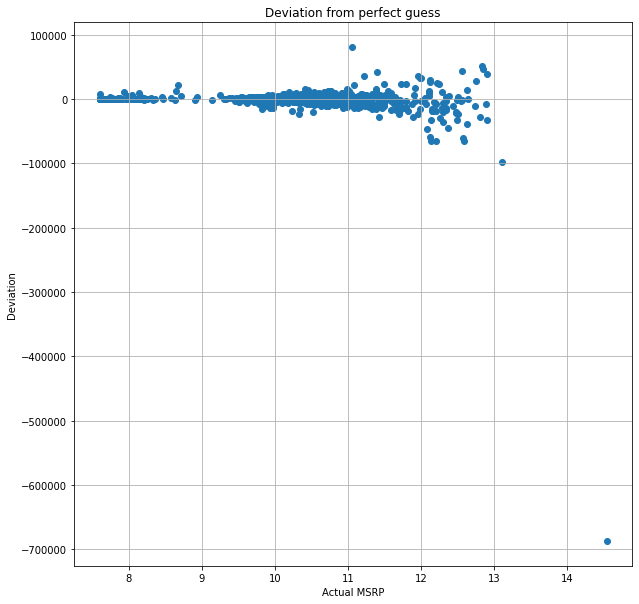

In [ ]:
deviation = np.exp(y_pred_test_rf) - np.exp(y_test) # Transforming back to original values

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, deviation)
ax.set_xlabel('Actual MSRP')
ax.set_ylabel('Deviation')
ax.set_title(f'Deviation from perfect guess')
x_val = np.linspace(0, 500000)
ax.grid()
plt.show()

---
# Discussion

- Why is Lasso and Linear Regression yielding similar results?

As we can see from the results, Lasso and Linear Regression models produced similar results. The reason for this could be due to the following. Based on the results of our grid search, an alpha value of 0.1 produced the most favourable outcomes for both the R2 score and RMSE. However, when the alpha value is close to zero, the influence of the regularization term diminishes, causing Lasso to resemble a standard linear regression model more closely. Secondly, after we performed EDA and feature engineering, we eliminated a considerable number of irrelevant features. Considering this, the remaining irrelevant features in the dataset may exert minimal impact and consequently, produce similar results. Lastly, in our case, the model for both Lasso and Linear Regression is relatively simple and the dataset is relatively small, the effect of regularization is not as pronounced, therefore leading to similar outcomes for both models.

- Why does Random Forest produce the best result?

As we can see from the results, Random Forest Regression model performed the best. The reasons for this could be because of the fact that Random Forest is relatively robust to the presence of outliers and noise in the data compared to Linear Regression and Lasso. Because Random Forest applies ensemble learning, meaning that the final prediction is made by averaging the outputs of all individual trees, which often results in better performance.

- Small difference between results when applying PCA vs not doing it

The very small difference between using PCA and not using PCA is quite evident by the fact that we very carefully examined what amount of principal components would not cause us to lose a significant amount of variance in the data. This meant that PCA in the end allowed us to make a more general model without losing significantly on the test scores. Choosing a lower threshold for desired explanation of variance (we chose 90%) could make the difference more obvious and could be investigated if we were to continue with the project.

- Why predict the logarithmic price?

When using the logarithm of the target variable, we get the relative difference between data points better represented because of the fact that the logarithm will smooth out any big jumps that are caused by outliers. The logarithm will suppress the range of large numbers while extending the range of the small ones.


**Improvements**

- Why the 70% rule?

The 70% rule, while a bit arbitrary, felt like a fair cutoff point of where two features would be too similar to have an “impact” separately. To further investigate this you could implement a rule using a lower percentage and feature engineer with these new results.

- Why 5 clusters?

5 clusters is a solid guess, as (not included in the report) when clustering with only categorical (using KModes instead of KPrototypes) the elbow plot clearly indicates 5 being a good choice of k for clustering. This could be further investigated, and try other k’s, to maybe improve our model.

- Should we try Cleaning the dataset and remove outliers/noise?

As mentioned we have quite a lot of outliers and noise, for example some cars have weird MPG (340 highway 24 city) which should be removed & quite a few outliers which will make the regression model have a large RMSE. The RMSE could be lowered removing the few cars with high prices OR introduce more cars with high prices, to allow the model to get more training on these higher prices. If we were to do a ‘real’ model we would try to get a more evenly distributed dataset or focusing on a price segment of cars that you want to use it on. (The focus should probably be on ‘everyday cars’ more than Bugattis)

- Should we run several splits?

When splitting the data, we currently only do so once. We might get more accurate results if we split multiple times, taking the average of several splits. Both when choosing the model and evaluating the test set.This way we could minimise the risk of getting a favourable split.


**To conclude:**

Our model performs admirably considering the huge difference between many of the cars and their idiosyncrasies. The RMSE is not insignificant since it exceeds the list price of some of the cars in the dataset however when the range in price (and very sparse in the higher price classes) is this wide then minimising the mean squared error becomes very difficult.


# Acknowledgments

As the majority of the project was done sitting beside each other at the same table it is hard to pinpoint everyone's exact contribution to the project. But here are examples of what each group member focused extra much on.

Elias:
The initial exploratory data analysis and visualisation of the data. Also the implementation and interpretation of the clustering algorithms.

Ludwig:
The work related to clustering, both implementing it and trying to figure out how to interpret it.

Oskar:
Basic EDA, working with PCA and providing proof it is a reasonable approach for our dataset. Applying, training and tuning our supervised models.

Leo:
Some failed experiments with agglomerative clustering for numerical features and testing PCA and some other unsupervised dimensionality reduction methods.


# Final meme



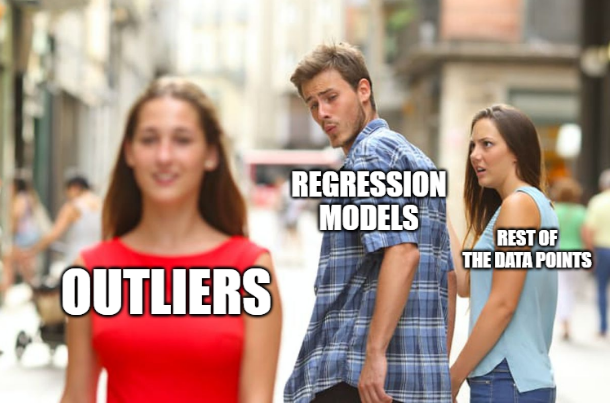